In [18]:
%pylab inline
%load_ext autoreload
%autoreload 2

import pandas as pd

# from matplotlib.colors import Lognorm
from scipy.integrate import simps
from time import time
import warnings
warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from ipywidgets import interact
import seaborn as sns
sns.set(palette='colorblind', style='whitegrid')
sns.set_style({'font.family': ['serif']})

In [20]:
from matplotlib.colors import LogNorm, SymLogNorm

In [21]:
from scipy.optimize import minimize
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import interp1d
from scipy import stats
from sklearn.metrics.pairwise import pairwise_kernels


In [22]:
sys.path.append('../cf_analysis/')
import tools

import glearn
from rscm import RSCM
import pcalearn
from sklearn.decomposition import PCA
from svdanalysis import SVDlearn
import synth

In [23]:
import yjtransform as yjt


# Setup

In [24]:
data = pd.read_csv('../The_Tax_Burden_on_Tobacco__1970-2017.csv')
sales = data[data['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)']
costs = data[data['SubMeasureDesc'] == 'Average Cost per pack ']    

In [25]:
# states = data['LocationDesc'].unique()
statesid = data['LocationAbbr'].unique()
sskip = ['CA', 'MA', 'AZ', 'OR', 'FL', 'AL', "HI", 'MD', 'MI','NJ', 'NY', 'WA', 'DC']
taxstates = ['CA', 'MA', 'OR', 'FL', 'AZ']


controlstates = []


ils, sil = {}, {}
for i in range(len(statesid)):
    ils[i] = statesid[i]
    sil[statesid[i]] = i
    if statesid[i] in sskip: continue
    else: controlstates.append(statesid[i])
        


In [26]:
for s in statesid:
    loc = sales['LocationAbbr'] == s
    years = sales[loc]['Year'].values.astype('float32')
    
years = years[years < 2000]
nyears = years.size
i1 = 18
yearspred =  years[i1:]
yy = years.size


In [27]:
statesales = {}
statecosts = {}
for s in statesid:
    loc = sales['LocationAbbr'] == s
    years = sales[loc]['Year'].values.astype('float64')
    years = years[years < 2000]
    statesales[s] = sales[loc]['Data_Value'].values.astype('float64')[:years.size]
    loc = costs['LocationAbbr'] == s
    statecosts[s] = costs[loc]['Data_Value'].values.astype('float64')[:years.size]
# ss = 'CO'
# tmp = statesales['CA'].copy()
# statesales['CA'] = statesales[ss].copy()
# statesales[ss] = tmp.copy()

salearray = np.zeros((len(ils), years.size))
for i in range(len(statesid)):
    salearray[i] = statesales[ils[i]]
    
costarray = np.zeros((len(ils), years.size))
for i in range(len(statesid)):
    costarray[i] = statecosts[ils[i]]
    
# salearrayca = []
# for i in range(len(statesid)):
#     if ils[i] == 'CA': continue
#     else: salearrayca.append(statesales[ils[i]])
# salearrayca = np.array(salearrayca)

salearrayskip = []
for i in range(len(statesid)):
    if ils[i] in sskip: continue
    else: salearrayskip.append(statesales[ils[i]])
salearrayskip = np.array(salearrayskip)
salearrayca = salearrayskip

# costarrayca = []
# for i in range(len(statesid)):
#     if ils[i] == 'CA': continue
#     else: costarrayca.append(statecosts[ils[i]])
# costarrayca = np.array(costarrayca)
costarrayskip = []
for i in range(len(statesid)):
    if ils[i] in sskip: continue
    else: costarrayskip.append(statecosts[ils[i]])
costarrayskip = np.array(costarrayskip)
costarrayca = costarrayskip

casales = statesales['CA']
meansales = salearrayca.mean(axis=0)

meansalesca = salearrayca.mean(axis=0)
stdsalesca = salearrayca.std(axis=0)
meansalesskip = salearrayskip.mean(axis=0)
cacosts = statecosts['CA']
meancosts = costarrayca.mean(axis=0)
meancostsskip = costarrayskip.mean(axis=0)


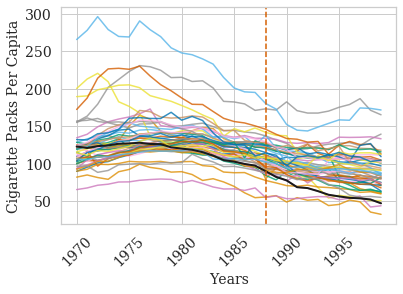

In [28]:
plt.plot(salearray.T, alpha=0.8)
plt.ylabel('Cigarette Packs Per Capita', fontsize=14)
plt.xlabel('Years', fontsize=14)
axis = plt.gca()
axis.set_xticks(np.arange(years.size)[::5])
axis.set_xticklabels(years[::5].astype(int))
matplotlib.pyplot.sca(axis)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.plot(salearray[4], color='k', lw=2)
plt.axvline(18, color='r', ls="--")
plt.show()


In [29]:
controls = []
for ss in controlstates: controls.append(statesales[ss])
controls = np.array(controls)
controls2 = np.array([statesales[ii] for ii in statesid if ii !='CA'])
treated = statesales['CA']
T0 = 18
xx = np.arange(meansalesca.size) + 1970
means = controls.mean(axis=0)
norm = controls.std(axis=0)
nT = controls.shape[1]

# Check


In [30]:
# pre_df = pd.read_pickle('./pca_dennis/pre_df_side_info.pkl')
# post_df = pd.read_pickle('./pca_dennis/post_df_side_info.pkl')
# columns = ['unit', 'intervention', 'metric']

# # sort dataframes by (unit, intervention)
# pre_df = pre_df.sort_values(by=columns)
# post_df = post_df.sort_values(by=columns)

# # get all unique interventions (from post-intervention dataframe)
# ivs = np.sort(pd.unique(post_df.intervention))

# # get all units (using pre-intervention data)
# units = list(np.sort(pd.unique(pre_df.unit)))

# # get all metrics
# metrics = list(np.sort(pd.unique(pre_df.metric)))

# # get number of units and interventions
# N, K, M = len(units), len(ivs), len(metrics)
# # T0 = pre_df.shape[1]-len(columns)
# # T = T0 + post_df.shape[1]-len(columns)
# # T1 = post_df.shape[1]-3

# iv = 'control'
# unit = 'California' 
# metric = metrics[0]
# t = 0.9999

# # get all units that received intervention 'iv' from POST-intervention data
# unit_ids = pd.unique(post_df[post_df.intervention==iv]['unit'])

# # exclude (target) unit from being included in (donor) unit_ids
# donor_units = unit_ids[unit_ids != unit] if unit in unit_ids else unit_ids
# num_donors = len(donor_units)
# yearslabel = pre_df.loc[(pre_df.unit.isin(donor_units))].columns[-19:]


# # get pre-intervention target data
# y1 = pre_df.loc[(pre_df.unit==unit)]
# # y1 = y1.drop(columns=columns).values.reshape(M*T0)
# y1 = y1[yearslabel].values.flatten()

# # get pre-intervention donor data
# X1 = pre_df.loc[(pre_df.unit.isin(donor_units))]
# # X1 = X1.drop(columns=columns).values.reshape(num_donors, M*T0).T 
# X1 = X1[yearslabel].values.T

# # loop through all metrics 
# X2 = post_df.loc[(post_df.unit.isin(donor_units)) & (post_df.intervention==iv) & (post_df.metric==metric)]
# X2 = X2.drop(columns=columns).values.T

# controlscheck = np.concatenate([X1, X2])
# treatedcheck = np.concatenate([y1, post_df.loc[(pre_df.unit==unit)].values.flatten()[3:]])

# plt.imshow((controls[:, :31]/controlscheck.T))
# plt.colorbar()

In [31]:

class GetObject(object):
    def __init__(self, *initial_data, **kwargs):
        for dictionary in initial_data:
            for key in dictionary:
                setattr(self, key, dictionary[key])
        for key in kwargs:
            setattr(self, key, kwargs[key])

            
xplot = years.copy()            


# Fourier Anlaysis

In [32]:
# gl = glearn.GLearn(controls, padl=nT, padr=nT, stdscale=False)
# plt.plot(gl.pkraw, marker='.')
# plt.plot(gl.pkprior, marker='.')
# plt.loglog()
# plt.show()

# glpred, glerr, glcov = gl.fit(treated, T0)

In [33]:
# bins = 30 
# normed = False
# # plt.hist((controls - means).flatten(), bins=bins, normed=normed, label='Data', alpha=0.6, color='C0')
# plt.hist((gl.controls-means).flatten(), bins=bins, normed=normed, label='Data', alpha=0.6, color='C0')
# plt.hist(gl.controlsg.flatten(), bins=bins, normed=normed, label='Transformed', alpha=0.6, color='C1')
# plt.legend()
# plt.show()
# # plt.hist(gca.controls.flatten())
# plt.show()

# plt.plot(years, treated)
# plt.errorbar(years, glpred, glerr)
# plt.plot(years, means)

# SCM

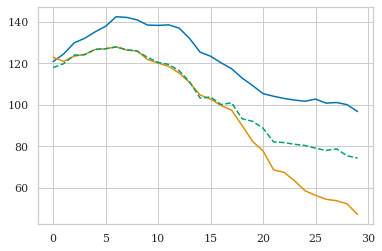

In [34]:
norm =1
yscm, wscm = synth.fit(controls/norm, treated/norm, T0, constraint=True, bound=True)
yscm = yscm * norm
plt.plot(means)
plt.plot(treated)
plt.plot(yscm, '--')
wscm;

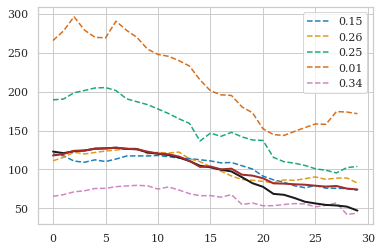

In [35]:

index = np.where(wscm > 0.01)[0]
for ii in index:
    plt.plot(controls[ii], label='%0.2f'%wscm[ii], ls='--', alpha=0.9)
plt.plot(treated, lw=2, color='k')
plt.plot(yscm, lw=2, color='brown')
plt.legend()

In [36]:
    
statesscm =  {}
for issn, ss in enumerate(statesid):    
    xx = np.array([statesales[iss] for iss in statesid if (iss !=ss) & (iss in controlstates)])
    means = xx.mean(axis=0)*0
    yy = statesales[ss]
    ##
    X1 = (xx - means)[:, :T0]
    X2 = (xx - means)[:, T0:]
    Y1 = (yy-means)[:T0]
    Y2 = (yy-means)[T0:]
    yp, wts = synth.fit(xx, yy, T0)
        
    statesscm[ss] = GetObject(controls=xx, treated=yy, pred=yp, wts=wts)
    

## Impact of normalization on svd

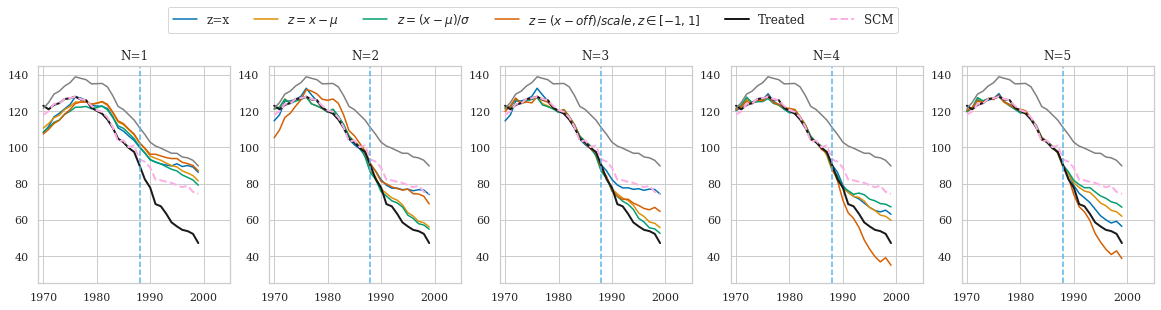

In [37]:
mmin, mmax = controls.min(), controls.max()
means, stds = controls.mean(axis=0), controls.std(axis=0)
mmin2, mmax2 = controls2.min(), controls2.max()
means2, stds2 = controls2.mean(axis=0), controls2.std(axis=0)
off, scale = (mmin + mmax)/2., (mmax - mmin)/2.
off2, scale2 = (mmin2 + mmax2)/2., (mmax2 - mmin2)/2.

ncomp = 2
def svdanalysis(fwd, bwd, x=controls, y=treated, ncomp=ncomp, T0=T0, scalefac=1):
    z = fwd(controls).T
    u, s, vh = np.linalg.svd(z, full_matrices=False)
    zv = np.dot(z, vh[:ncomp, :].T)
    tomin = lambda p: (((fwd(y)[:T0]) - np.dot(zv, p)[:T0])**2).sum()
    ppsvd = minimize(tomin, np.zeros(ncomp)).x
    ysvd = bwd(np.dot(zv, ppsvd)) 
    return ysvd



fig, ax = plt.subplots(1, 5, figsize=(20, 4))

xx = controls2.copy()
mmin, mmax = xx.min(), xx.max()
means, stds = xx.mean(axis=0), xx.std(axis=0)
off, scale = (mmin + mmax)/2., (mmax - mmin)/2.

for i in range(1, 6):
    lbl = None
    if i == 1: lbl = 'z=x'
    fwd = lambda x: x
    bwd = lambda x: x
    ax[i-1].plot(years, svdanalysis(fwd, bwd, x=xx, ncomp=i), label=lbl)

    if i == 1: lbl = '$z = x-\mu$'
    fwd = lambda x: x - means
    bwd = lambda x: x + means
    ax[i-1].plot(years, svdanalysis(fwd, bwd, x=xx, ncomp=i), label=lbl)

    if i == 1: lbl = '$z=(x-\mu)/\sigma$'
    fwd = lambda x: (x - means)/stds
    bwd = lambda x: x*stds + means
    ax[i-1].plot(years, svdanalysis(fwd, bwd, x=xx, ncomp=i), label=lbl)

    if i == 1: lbl = '$z= (x-off)/scale, z\in[-1, 1]$'
    fwd = lambda x: (x - off)/scale
    bwd = lambda x: x*scale + off
    ax[i-1].plot(years, svdanalysis(fwd, bwd, x=xx, ncomp=i), label=lbl)
    ax[i-1].set_title("N=%d"%i, fontsize=12)

yscm = synth.fit(controls, treated, T0)[0]
for axis in ax:
    axis.plot(years, treated, 'k', lw=2, label='Treated')
    axis.plot(years, yscm, 'C6--', lw=2, label='SCM')
    axis.plot(years, means, 'gray')
    axis.set_xlim(1969, 2005)
    axis.set_ylim(25, 145)
    axis.axvline(1988, color='c', ls='--')
    ax[0].legend(ncol=6, bbox_to_anchor=(4.5, 1.3), fontsize=12)

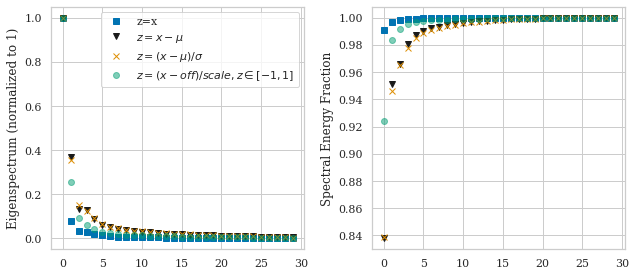

In [38]:
ncomp = 2

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
lbl = 'z=x'
fwd = lambda x: x
bwd = lambda x: x
ss = np.linalg.svd(fwd(xx), compute_uv=False)
ysvd = svdanalysis(fwd, bwd, x=xx, ncomp=ncomp)
ax[0].plot(ss/ss.max(), 's', label=lbl)
ax[1].plot(np.cumsum(ss**2)/(ss**2).sum(), 's', label=lbl)

lbl = '$z = x-\mu$'
fwd = lambda x: x - means
bwd = lambda x: x + means
ss = np.linalg.svd(fwd(xx), compute_uv=False)
ysvdcenter = svdanalysis(fwd, bwd, x=xx, ncomp=ncomp)
ax[0].plot(ss/ss.max(), 'kv', label=lbl)
ax[1].plot(np.cumsum(ss**2)/(ss**2).sum(), 'kv', label=lbl)

lbl = '$z=(x-\mu)/\sigma$'
fwd = lambda x: (x - means)/stds
bwd = lambda x: x*stds + means
ss = np.linalg.svd(fwd(xx), compute_uv=False)
ysvdstd = svdanalysis(fwd, bwd, x=xx, ncomp=ncomp)
ax[0].plot(ss/ss.max(), 'x', label=lbl)
ax[1].plot(np.cumsum(ss**2)/(ss**2).sum(), 'x', label=lbl)

lbl = '$z= (x-off)/scale, z\in[-1, 1]$'
fwd = lambda x: (x - off)/scale
bwd = lambda x: x*scale + off
ss = np.linalg.svd(fwd(xx), compute_uv=False)
ysvdunit = svdanalysis(fwd, bwd, x=xx, ncomp=ncomp)
ax[0].plot(ss/ss.max(), 'o', label=lbl, alpha=0.5)
ax[1].plot(np.cumsum(ss**2)/(ss**2).sum(), 'o', label=lbl, alpha=0.5)

ax[0].legend()
ax[0].set_ylabel('Eigenspectrum (normalized to 1)')
ax[1].set_ylabel('Spectral Energy Fraction')
plt.tight_layout()
# plt.yscale('log')
# plt.ylim(0.05, 1)

In [39]:
# ncomp = 2
# z1 = controls.copy().T
# u1, s1, vh1 = np.linalg.svd(z1, full_matrices=False)
# zv = np.dot(z1, vh1[:ncomp, :].T)
# z2 = (controls-means).T
# u2, s2, vh2 = np.linalg.svd(z2, full_matrices=False)
# zv2 = np.dot(z2, vh2[:ncomp, :].T)
# z3 = pcl.normalize(controls).T
# u3, s3, vh3 = np.linalg.svd(z3, full_matrices=False)
# zv3 = np.dot(z3, vh3[:ncomp, :].T)

# # u1.shape, vh1.shape
# # np.dot(np.dot(u1, np.diag(s1)), vh1)/z1


# plt.plot(zv.T[0], 'C0')
# plt.plot(zv.T[1], 'C1')
# plt.plot(zv2.T[0], 'C0--')
# plt.plot(zv2.T[1], 'C1--')
# plt.plot(zv3.T[0], 'C0:')
# plt.plot(zv3.T[1], 'C1:')
# # plt.plot(zv3.T[0] * (controls.max()-controls.min())/2., 'C0:')
# # plt.plot(zv3.T[1] * (controls.max()-controls.min())/2., 'C1:')
# # plt.plot(means, "C2:")

# PCA Analysis

6
33.47904789700295 0.0


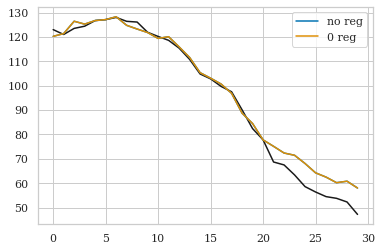

In [40]:
i = 0 
ncomp = tools.approximate_rank(controls-means, t=0.99)
print(ncomp)
# ncomp = 5

mmin, mmax = controls.min(), controls.max()
means = controls.mean(axis=0)
stds = controls.std(axis=0)
# 
pcl = pcalearn.PCAlearn(controls, ncomp, normalization='center')
pca = pcl.pca
errpca = pcl.cov.diagonal()**0.5
ypca, pp = pcl.fit(treated, T0, regwt=None, verbose=True) 
ypcar, ppr = pcl.fit(treated, T0, regwt=0, verbose=1) 
# ypcar2, ppr2 = pcl.fit(treated, T0, regwt=np.logspace(-4, -2, 100), verbose=True)

meancond, covcond = pcl.conditional_gaussian(treated[:T0])
meancond = np.concatenate([treated[:T0], meancond]) 
errcond = (covcond.diagonal()**0.5)
errcond = np.concatenate([treated[:T0]*0, errcond])


plt.plot(treated, 'k')
plt.plot(ypca, label='no reg')
plt.plot(ypcar, label='0 reg')
# plt.plot(ypcar2, '--',lw=2, alpha=0.5, label='grid reg')
plt.legend()

# SVD

In [41]:
ncomp0 = tools.approximate_rank(controls, t=0.99)
ncompc = tools.approximate_rank(controls-means, t=0.99)
print(ncomp0, ncompc)


1 6


### How many components?

(1, 10000.0)

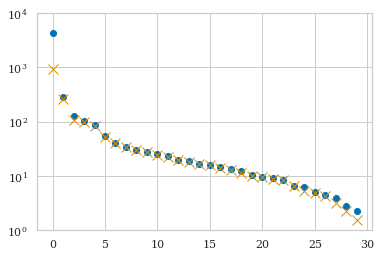

In [42]:
xx = controls.copy()
u, s, vh = np.linalg.svd(xx, full_matrices=False)
plt.plot(s, 'o')

xx = controls.copy() - controls.mean(axis=0)
u, s, vh = np.linalg.svd(xx, full_matrices=False)
plt.plot(s, 'x', markersize=10)
plt.semilogy()
plt.ylim(1, 1e4)

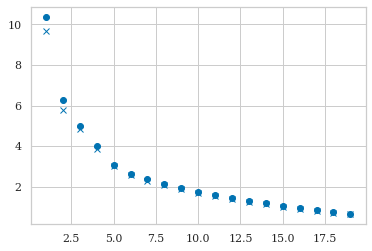

In [43]:
xx = controls.copy()
u, s, vh = np.linalg.svd(xx, full_matrices=False)

for nc in range(1, 20):
    plt.plot(nc, (xx - np.dot(u[:, :nc]*s[:nc], vh[:nc])).std(), 'bo')
#     plt.plot(nc, (xx - np.dot(u[:, :nc]*s[:nc], vh[:nc])).mean(), 'ro')

xx = controls.copy() - controls.mean(axis=0)
u, s, vh = np.linalg.svd(xx, full_matrices=False)
for nc in range(1, 20):
    plt.plot(nc, (xx - np.dot(u[:, :nc]*s[:nc], vh[:nc])).std(), 'bx')
#     plt.plot(nc, (xx - np.dot(u[:, :nc]*s[:nc], vh[:nc])).std(), 'rx')

Text(0, 0.5, 'centering')

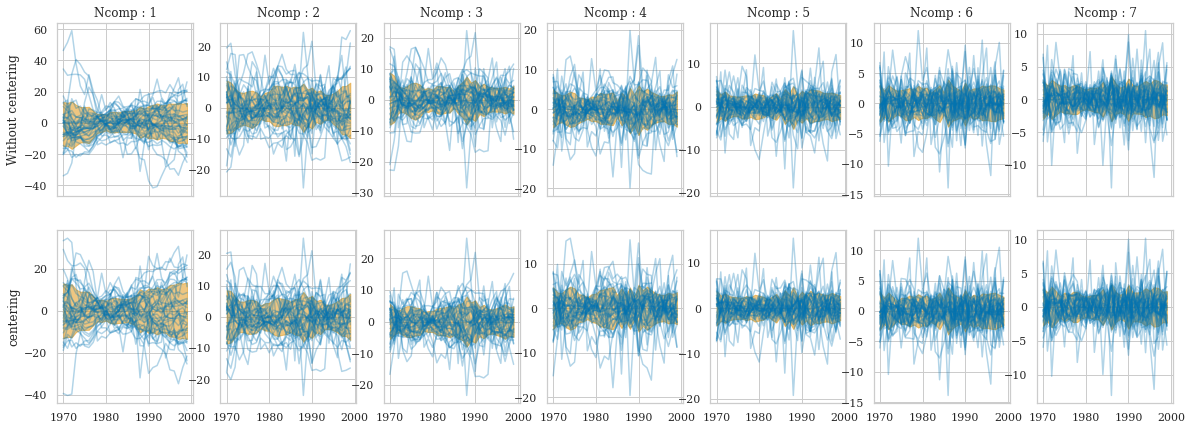

In [44]:
ncmax = 7
fig, ax = plt.subplots(2, ncmax, figsize=(20, 7), sharey=False, sharex=True)

xx = controls.copy()
u, s, vh = np.linalg.svd(xx, full_matrices=False)

for nc in range(1, ncmax+1):
    dd = (xx - np.dot(u[:, :nc]*s[:nc], vh[:nc]))    
    ax[0, nc-1].plot(years, dd.T, 'b', alpha=0.3)
    ax[0, nc-1].fill_between(years, dd.mean(axis=0) - dd.std(axis=0), dd.mean(axis=0) + dd.std(axis=0), color='C1', alpha=0.5)
    ax[0, nc-1].set_title("Ncomp : %d"%nc)
ax[0, 0].set_ylabel('Without centering')

xx = controls.copy() - controls.mean(axis=0)
u, s, vh = np.linalg.svd(xx, full_matrices=False)

for nc in range(1, ncmax+1):
    dd = (xx - np.dot(u[:, :nc]*s[:nc], vh[:nc]))    
    ax[1, nc-1].plot(years, dd.T, 'b', alpha=0.3)
    ax[1, nc-1].fill_between(years, dd.mean(axis=0) - dd.std(axis=0), dd.mean(axis=0) + dd.std(axis=0), color='C1', alpha=0.5)
ax[1, 0].set_ylabel('centering')



## HSVT

3 3
5


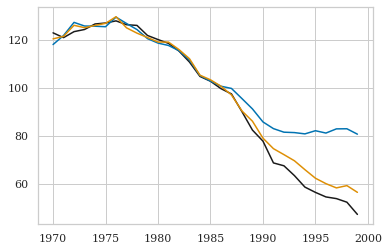

In [45]:
from hsvtanalysis import hsvt_fit 
yhsvt, bhsvt = hsvt_fit(controls, treated, T0, t=0.999, verbose=True)
yhsvtc, bhsvtc = hsvt_fit(controls, treated, T0, t=0.999, verbose=True, combined=True)

plt.plot(years, treated, 'k')
plt.plot(years, yhsvt)
plt.plot(years, yhsvtc)

1 6


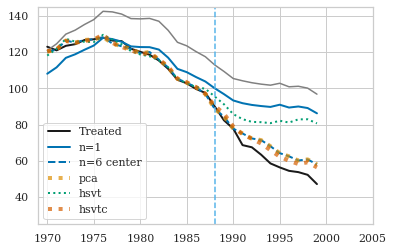

In [46]:

plt.plot(years, treated, 'k', lw=2, label='Treated')
plt.plot(years, means, 'gray')

sv0 = SVDlearn(controls, normalization=None)
svc = SVDlearn(controls, normalization='center')

ncomp0 = tools.approximate_rank(controls, t=0.99)
ncompc = tools.approximate_rank(controls-means, t=0.99)
print(ncomp0, ncompc)

# ncomp = 3
# plt.plot(years, sv0.fit(treated, T0, n_components=ncomp)[0], 'C0', label='n=%d'%ncomp)
# plt.plot(years, svc.fit(treated, T0, n_components=ncomp)[0], 'C0--', label='n=%d'%ncomp)
# ncomp = 9
ysv0, ysvc = sv0.fit(treated, T0, n_components=ncomp0)[0], svc.fit(treated, T0, n_components=ncompc)[0]
plt.plot(years, ysv0, 'C0', label='n=%d'%ncomp0, lw=2)
plt.plot(years, ysvc, 'C0--', label='n=%d center'%ncompc, lw=2)


plt.plot(years, ypca, 'C1:', lw=4, label='pca', alpha=0.7)
plt.plot(years, yhsvt, 'C2:', lw=2, label='hsvt')
plt.plot(years, yhsvtc, 'C3:', lw=4, label='hsvtc', alpha=0.7)
plt.xlim(1969, 2005)
plt.ylim(25, 145)
plt.axvline(1988, color='c', ls='--')
plt.legend()

# RSCM

In [47]:

rr = RSCM(controls, 2, normalization=None)
yrscm = rr.fit(treated, T0, regwt=None)

rrcenter = RSCM(controls, 9, normalization='center')
yrscmcenter = rrcenter.fit(treated, T0, regwt=None)

# rrstd = RSCM(controls, 2, normalization='center', stdscale=True)
# yrscmstd = rrstd.fit(treated, T0, regwt=np.logspace(-3, 2))

# rrunit = RSCM(controls, 2, normalization='minmax')
# yrscmunit = rrunit.fit(treated, T0, regwt=np.logspace(-4, 1))
# yrscm = rr.fit(treated, T0, regwt=1)

No regularization
No regularization


(1970, 2005)

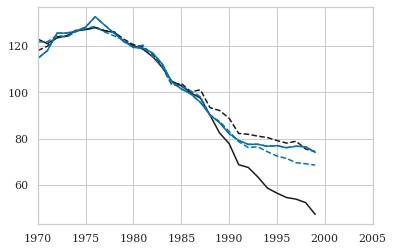

In [48]:
plt.plot(years, treated, 'k-')
plt.plot(years, yscm, 'k--')

plt.plot(years, ysvd, 'C0')
plt.plot(years, yrscm[0], 'C0--')
plt.plot(years, yrscmcenter[0], 'C0--')

plt.xlim(1970, 2005)
# plt.plot(years, ysvdunit, 'C3')
# plt.plot(years, yrscmunit[0], 'C3--')


In [49]:
# xx =  years
# plt.plot(xx, meansalesca, 'gray', ls='--', lw=3, alpha=0.7, label='Mean')
# plt.plot(xx, treated, 'cyan', label='Data')
# plt.plot(xx, yscm, 'C4', label='SCM')
# plt.plot(xx, glpred, 'C0', label='Fourier')
# # plt.fill_between(xx, capred-err, capred+err, color='C0', alpha=0.3)


# plt.plot(xx, meancond, 'C1--', lw=2, label='CGP')
# # plt.fill_between(xx, meancond-errcond, meancond+errcond, color='C1', alpha=0.2)

# # plt.plot(xx, ypca, 'C2--', lw=2, label='PCA-5')
# # plt.fill_between(xx, ypca-errpca, ypca+errpca, color='C2', alpha=0.2)


# plt.axvline(xx[0] + T0, color='k')
# plt.legend()


# KDE

4 5


(1970, 2005)

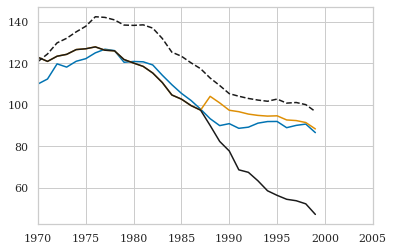

In [78]:

import kde
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.base import BaseEstimator, RegressorMixin
KernelRegression = kde.KernelRegression


def get_ykde(gg, X1, X2, Y1, means, gamma=np.logspace(-3, 1, 1000), caty1=True):
    kde = KernelRegression(gg, gamma=gamma)
    kde.fit(X1, X2)
    if len(Y1.shape) <=1: Y1 =  Y1.reshape(1,-1)
    ykde, wts = kde.predict(Y1, retK=True)
    ykde0 = kde.predict(Y1, X1, retK=False)
    ykde = ykde.flatten()
    ykde0 = ykde0.flatten()
    if caty1 == 1: ykde = np.concatenate([Y1.flatten(), ykde]) #+ means
    elif caty1 == 2: ykde = np.concatenate([ykde0, ykde]) #+ means
    return ykde, kde, wts
    
means = controls.mean(axis=0)
X1 = (controls - means)[:, :T0]
X2 = (controls - means)[:, T0:]
Y1 = (treated-means)[:T0]
Y2 = (treated-means)[T0:]
ykdec = get_ykde('rbf', X1, X2, Y1, means, caty1=2)
ykde, _, _ = get_ykde('rbf', X1+means[:T0], X2+means[T0:], Y1+means[:T0], means*0, caty1=2)
# ykde += means


nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
print(nc1, nc2)
p1, p2 = PCA(nc1, whiten=True).fit(X1), PCA(nc2, whiten=True).fit(X2)
XX1, XX2 = p1.transform(X1), p2.transform(X2)
YY1 = p1.transform(Y1.reshape(1,-1))
ykdep, _, _ = get_ykde('rbf', XX1, XX2, YY1, means=0, caty1=False)
ykdep = np.concatenate([Y1, p2.inverse_transform(ykdep)]) + means
# ykdepcos = get_ykde('cosine', XX1, XX2, YY1, means=0, caty1=False, gamma=None)
# ykdepcos = np.concatenate([Y1, p2.inverse_transform(ykdepcos)]) + means
# ykde = get_ykde(gg, X1+means[:T0], X2+means[T0:], Y1+means[:T0], means*0)



plt.plot(years, ykde)
plt.plot(years, ykdep)
# plt.plot(years, ykdec)
plt.plot(years, means, 'k--')
plt.plot(years, treated, 'k')
# plt.plot(years, yscm, '--')
# plt.plot(years, ysv0, '--')
# plt.plot(years, ysvc, '--')
plt.xlim(1970, 2005)

In [87]:
# stateskdevanilla =  {}
# # for ss in ['CA']:
# for issn, ss in enumerate(statesid):    
#     xx = np.array([statesales[iss] for iss in statesid if (iss !=ss) & (iss in controlstates)])
#     means = xx.mean(axis=0)*0
#     yy = statesales[ss]
#     ##
#     X1 = (xx - means)[:, :T0]
#     X2 = (xx - means)[:, T0:]
#     Y1 = (yy-means)[:T0]
#     Y2 = (yy-means)[T0:]
#     yp, kde, wts = get_ykde('rbf', X1, X2, Y1, means, caty1=2)
#     yp += means
#     stateskdevanilla[ss] = GetObject(controls=xx, treated=yy, kde=kde, pred=yp, wts=wts)


# stateskde =  {}
# # for ss in ['CA']:
# for issn, ss in enumerate(statesid):    
#     xx = np.array([statesales[iss] for iss in statesid if (iss !=ss) & (iss in controlstates)])
#     means = xx.mean(axis=0)
#     yy = statesales[ss]
#     ##
#     X1 = (xx - means)[:, :T0]
#     X2 = (xx - means)[:, T0:]
#     Y1 = (yy-means)[:T0]
#     Y2 = (yy-means)[T0:]
#     yp, kde, wts = get_ykde('rbf', X1, X2, Y1, means, caty1=2)
#     yp += means        
#     stateskde[ss] = GetObject(controls=xx, treated=yy, kde=kde, pred=yp, wts=wts)


# stateskdestd =  {}
# # for ss in ['CA']:
# for issn, ss in enumerate(statesid):    
#     xx = np.array([statesales[iss] for iss in statesid if (iss !=ss) & (iss in controlstates)])
#     means = xx.mean(axis=0)
#     stds = xx.std(axis=0)
#     yy = statesales[ss]
#     ##
#     X1 = ((xx - means)/stds)[:, :T0]
#     X2 = ((xx - means)/stds)[:, T0:]
#     Y1 = ((yy-means)/stds)[:T0]
#     Y2 = ((yy-means)/stds)[T0:]
#     yp, kde, wts = get_ykde('rbf', X1, X2, Y1, means, caty1=2)
#     yp = yp*stds + means
        
#     stateskdestd[ss] = GetObject(controls=xx, treated=yy, kde=kde, pred=yp, wts=wts)

    
stateskdepca =  {}
# for ss in ['CA']:
for issn, ss in enumerate(statesid):    
    xx = np.array([statesales[iss] for iss in statesid if (iss !=ss) & (iss in controlstates)])
    means = xx.mean(axis=0)
    stds = xx.std(axis=0)
    yy = statesales[ss]
    ##
    X1 = ((xx - means)/stds)[:, :T0]
    X2 = ((xx - means)/stds)[:, T0:]
    Y1 = ((yy-means)/stds)[:T0]
    Y2 = ((yy-means)/stds)[T0:]
    nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
#     nc1, nc2 = 9, 9
    if nc1 <=1 : nc1 +=1 
    if nc2 <=1 : nc2 +=1 
    p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
    XX1, XX2 = p1.transform(X1), p2.transform(X2)
    YY1 = p1.transform(Y1.reshape(1,-1))
    ykdep, kde, wts = get_ykde('rbf', XX1, XX2, YY1, means=0, caty1=2)
    y1, y2 = ykdep[:nc1], ykdep[nc1:]
    yp = np.concatenate([p1.inverse_transform(y1), p2.inverse_transform(y2)]) 
    yp = yp * stds + means
        
    stateskdepca[ss] = GetObject(controls=xx, treated=yy, kde=kde, pred=yp, wts=wts, nc1=nc1, nc2=nc2)

    
    
    
# stateskdepca3 =  {}
# # for ss in ['CA']:
# for issn, ss in enumerate(statesid):    
#     xx = np.array([statesales[iss] for iss in statesid if (iss !=ss) & (iss in controlstates)])
#     means = xx.mean(axis=0)
#     yy = statesales[ss]
#     ##
#     X1 = (xx - means)[:, :T0]
#     X2 = (xx - means)[:, T0:]
#     Y1 = (yy-means)[:T0]
#     Y2 = (yy-means)[T0:]
#     nc1, nc2 = 3, 3 # tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
#     if nc1 <=1 : nc1 +=1 
#     if nc2 <=1 : nc2 +=1 
#     p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
#     XX1, XX2 = p1.transform(X1), p2.transform(X2)
#     YY1 = p1.transform(Y1.reshape(1,-1))
#     ykdep, kde, wts = get_ykde('rbf', XX1, XX2, YY1, means=0, caty1=2)
#     y1, y2 = ykdep[:nc1], ykdep[nc1:]
#     yp = np.concatenate([p1.inverse_transform(y1), p2.inverse_transform(y2)]) + means
        
#     stateskdepca3[ss] = GetObject(controls=xx, treated=yy, kde=kde, pred=yp, wts=wts)
    

In [88]:
diffscm, diffhsvt  = np.zeros_like(controls), np.zeros_like(controls)

diffkdevanilla, diffkde, diffkdestd, diffkdepca, diffkdepca3 = np.zeros_like(controls), np.zeros_like(controls),  \
                np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls)

for ii, ss in enumerate(controlstates):
    xx = stateskde[ss].controls
    yy = stateskde[ss].treated

    diffscm[ii] = (yy-statesscm[ss].pred)
    diffkde[ii] = (yy-stateskde[ss].pred)
    diffkdevanilla[ii] = (yy-stateskdevanilla[ss].pred)
    diffkdestd[ii] = (yy-stateskdestd[ss].pred)
    diffkdepca[ii] = (yy-stateskdepca[ss].pred)
    diffkdepca3[ii] = (yy-stateskdepca3[ss].pred)
    


(-50, 50)

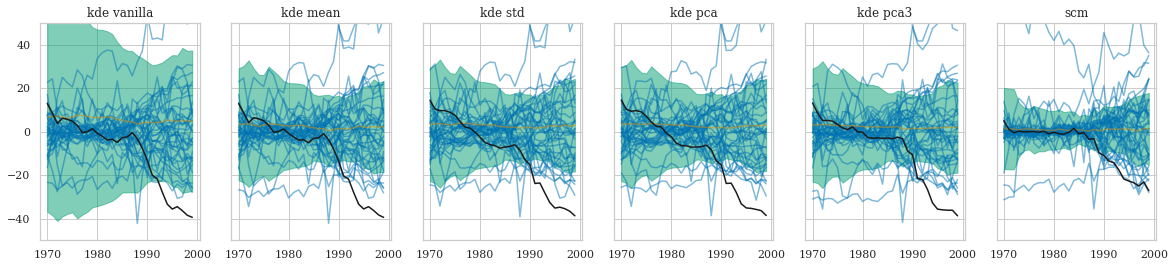

In [89]:
fig, ax = plt.subplots(1, 6, figsize=(20, 4), sharex=True, sharey=True)


tmpy = stateskde['CA'].treated

def tmpplot(ii, title, dd, ddca):
    ax[ii].plot(years, dd.T, 'C0-', alpha=0.5)
    ax[ii].plot(years, dd.mean(axis=0), 'C1', alpha=0.5)
    ax[ii].fill_between(years, dd.mean(axis=0) - dd.std(axis=0), dd.mean(axis=0) + dd.std(axis=0), color='C2', alpha=0.5)
    ax[ii].plot(years, tmpy - ddca, 'k-', alpha=1)
    ax[ii].set_title(title)
#     ax[ii].grid(which='both')

tmpplot(0, 'kde vanilla', diffkdevanilla, stateskdevanilla['CA'].pred )
tmpplot(1, 'kde mean', diffkde, stateskde['CA'].pred )
tmpplot(2, 'kde std', diffkdestd, stateskdestd['CA'].pred )
tmpplot(3, 'kde pca', diffkdepca, stateskdepca['CA'].pred )
tmpplot(4, 'kde pca3', diffkdepca3, stateskdepca3['CA'].pred )
tmpplot(5, 'scm', diffscm, statesscm['CA'].pred )
plt.ylim(-50, 50)

[]

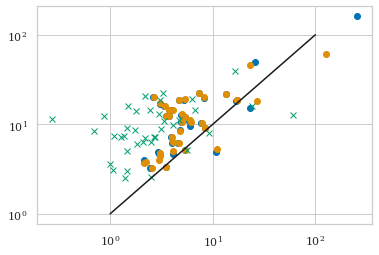

In [85]:
plt.plot((diffkdevanilla[:, :T0]**2).mean(axis=1)**0.5, (diffkdevanilla[:, T0:]**2).mean(axis=1)**0.5, 'o')
plt.plot((diffkde[:, :T0]**2).mean(axis=1)**0.5, (diffkde[:, T0:]**2).mean(axis=1)**0.5, 'o')
plt.plot((diffscm[:, :T0]**2).mean(axis=1)**0.5, (diffscm[:, T0:]**2).mean(axis=1)**0.5, 'x')
plt.plot([1, 100], [1, 100], 'k')
plt.loglog()

(-50, 50)

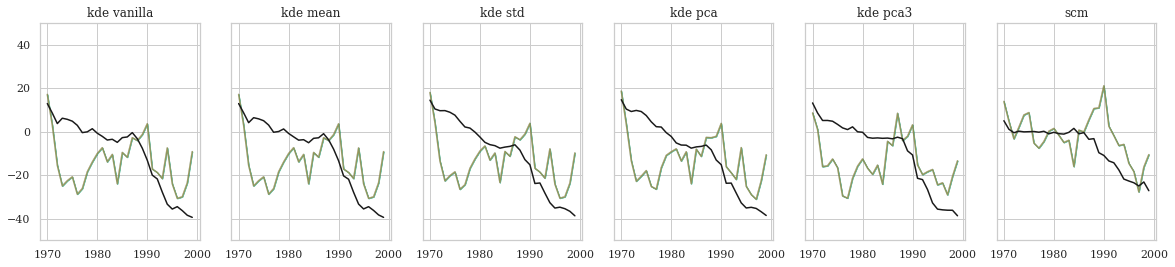

In [86]:
fig, ax = plt.subplots(1, 6, figsize=(20, 4), sharex=True, sharey=True)


tmpy = stateskde['CA'].treated

def tmpplot(ii, title, dd, ddca):
    ax[ii].plot(years, dd.T, 'C0-', alpha=0.5)
    ax[ii].plot(years, dd.mean(axis=0), 'C1', alpha=0.5)
    ax[ii].fill_between(years, dd.mean(axis=0) - dd.std(axis=0), dd.mean(axis=0) + dd.std(axis=0), color='C2', alpha=0.5)
    ax[ii].plot(years, tmpy - ddca, 'k-', alpha=1)
    ax[ii].set_title(title)
#     ax[ii].grid(which='both')

ii = slice(19, 20)
tmpplot(0, 'kde vanilla', diffkdevanilla[ii], stateskdevanilla['CA'].pred )
tmpplot(1, 'kde mean', diffkde[ii], stateskde['CA'].pred )
tmpplot(2, 'kde std', diffkdestd[ii], stateskdestd['CA'].pred )
tmpplot(3, 'kde pca', diffkdepca[ii], stateskdepca['CA'].pred )
tmpplot(4, 'kde pca3', diffkdepca3[ii], stateskdepca3['CA'].pred )
tmpplot(5, 'scm', diffscm[ii], statesscm['CA'].pred )
plt.ylim(-50, 50)

# GP

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
RBF = kernels.RBF
WhiteKernel = kernels.WhiteKernel

xx = controls.copy()
yy = treated.copy()
means = xx.mean(axis=0)*1
stds = xx.std(axis=0)*1# + 1
xx = (xx - means)/stds
yy = (yy - means)/stds

# plt.plot(xx.T);
# plt.plot(xxp.T, '--');
# plt.plot(yy, 'k')
# plt.show()

xxp = xx.copy()
gp = GPR(kernels.RBF(0.01), n_restarts_optimizer=100).fit(xxp[:, :T0], xxp[:, T0:])
gp.log_marginal_likelihood_value_, gp.kernel_
yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1))) * stds[T0:] + means[T0:]
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100)).T * stds[T0:] + means[T0:]
ystd = ysample.std(axis=0)
plt.plot(years, yy*stds + means, 'k')
plt.plot(years[T0:], yp, color= 'C0', lw=2)
plt.fill_between(years[T0:], yp-ystd, yp+ystd, color= 'C0', alpha=0.2);

nc = 3
pca =  PCA(nc).fit(xx)
xxp = pca.inverse_transform(pca.transform(xx))
gp = GPR(kernels.RBF(0.01), n_restarts_optimizer=100).fit(xxp[:, :T0], xxp[:, T0:])
gp.log_marginal_likelihood_value_, gp.kernel_
yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1))) * stds[T0:] + means[T0:]
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100)).T * stds[T0:] + means[T0:]
ystd = ysample.std(axis=0)
plt.plot(years, yy*stds + means, 'k')
plt.plot(years[T0:], yp, color= 'C1', lw=2)
plt.fill_between(years[T0:], yp-ystd, yp+ystd, color= 'C1', alpha=0.2);

#
pca =  PCA(nc).fit(xx)
xxp = pca.inverse_transform(pca.transform(xx))
alpha = (xx - xxp).std(axis=0)
# alpha = np.repeat(alpha.reshape(1, -1), xx.shape[0], axis=0)
gp = GPR(kernels.RBF(0.01), n_restarts_optimizer=100, alpha=(xx - xxp).std()).fit(xxp[:, :T0], xxp[:, T0:])
gp.log_marginal_likelihood_value_, gp.kernel_
yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1))) * stds[T0:] + means[T0:]
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100)).T * stds[T0:] + means[T0:]
ystd = ysample.std(axis=0)
plt.plot(years, yy*stds + means, 'k')
plt.plot(years[T0:], yp, 'C2--', lw=2)
plt.fill_between(years[T0:], yp-ystd, yp+ystd, color= 'C2', alpha=0.2);

nc = 5
pca =  PCA(nc).fit(xx)
xxp = pca.inverse_transform(pca.transform(xx))
gp = GPR(kernels.RBF(0.01), n_restarts_optimizer=100).fit(xxp[:, :T0], xxp[:, T0:])
gp.log_marginal_likelihood_value_, gp.kernel_
yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1))) * stds[T0:] + means[T0:]
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100)).T * stds[T0:] + means[T0:]
ystd = ysample.std(axis=0)
plt.plot(years, yy*stds + means, 'k')
plt.plot(years[T0:], yp, color= 'C3', lw=2)
plt.fill_between(years[T0:], yp-ystd, yp+ystd, color= 'C3', alpha=0.2);

#
pca =  PCA(nc).fit(xx)
xxp = pca.inverse_transform(pca.transform(xx))
alpha = (xx - xxp).std(axis=0)
# alpha = np.repeat(alpha.reshape(1, -1), xx.shape[0], axis=0)
gp = GPR(kernels.RBF(0.01), n_restarts_optimizer=100, alpha=(xx - xxp).std()).fit(xxp[:, :T0], xxp[:, T0:])
gp.log_marginal_likelihood_value_, gp.kernel_
yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1))) * stds[T0:] + means[T0:]
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100)).T * stds[T0:] + means[T0:]
ystd = ysample.std(axis=0)
plt.plot(years, yy*stds + means, 'k')
plt.plot(years[T0:], yp, 'C4--', lw=2)
plt.fill_between(years[T0:], yp-ystd, yp+ystd, color= 'C4', alpha=0.2);


nc = 7
pca =  PCA(nc).fit(xx)
xxp = pca.inverse_transform(pca.transform(xx))
gp = GPR(kernels.RBF(0.01), n_restarts_optimizer=100).fit(xxp[:, :T0], xxp[:, T0:])
gp.log_marginal_likelihood_value_, gp.kernel_
yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1))) * stds[T0:] + means[T0:]
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100)).T * stds[T0:] + means[T0:]
ystd = ysample.std(axis=0)
plt.plot(years, yy*stds + means, 'k')
plt.plot(years[T0:], yp, color= 'C5', lw=2)
plt.fill_between(years[T0:], yp-ystd, yp+ystd, color= 'C5', alpha=0.2);

#
pca =  PCA(nc).fit(xx)
xxp = pca.inverse_transform(pca.transform(xx))
alpha = (xx - xxp).std(axis=0)
# alpha = np.repeat(alpha.reshape(1, -1), xx.shape[0], axis=0)
gp = GPR(kernels.RBF(0.01), n_restarts_optimizer=100, alpha=(xx - xxp).std()).fit(xxp[:, :T0], xxp[:, T0:])
gp.log_marginal_likelihood_value_, gp.kernel_
yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1))) * stds[T0:] + means[T0:]
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100)).T * stds[T0:] + means[T0:]
ystd = ysample.std(axis=0)
plt.plot(years, yy*stds + means, 'k')
plt.plot(years[T0:], yp, 'C6--', lw=2)
plt.fill_between(years[T0:], yp-ystd, yp+ystd, color= 'C6', alpha=0.2);

plt.show()

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
RBF = kernels.RBF
Matern = kernels.Matern
WhiteKernel = kernels.WhiteKernel

# xx = controls.copy()
# yy = treated.copy()

xx = statesscm['CA'].controls.copy()
yy = statesscm['CA'].treated.copy()
means = xx.mean(axis=0)*1
stds = xx.std(axis=0)*1# + 1
xx = (xx - means)/stds
yy = (yy - means)/stds

xxp = xx.copy()
gp = GPR(kernels.RBF(0.01), n_restarts_optimizer=100).fit(xxp[:, :T0], xxp[:, T0:])
print(gp.kernel_)
yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1))) * stds[T0:] + means[T0:]
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100)).T * stds[T0:] + means[T0:]
ystd = ysample.std(axis=0)
plt.plot(years, yy*stds + means, 'k')
plt.plot(years[T0:], yp, color= 'C0', lw=2)
plt.fill_between(years[T0:], yp-ystd, yp+ystd, color= 'C0', alpha=0.2);

xxp = xx.copy()
# gp = GPR(kernels.RBF(1.*np.ones_like(yy[:T0]), length_scale_bounds=(1e-3, 10)), n_restarts_optimizer=1000).fit(xxp[:, :T0], xxp[:, T0:])
# gp = GPR(kernels.ExpSineSquared(1), n_restarts_optimizer=100).fit(xxp[:, :T0], xxp[:, T0:])
gp = GPR(kernels.RationalQuadratic(1), n_restarts_optimizer=1000).fit(xxp[:, :T0], xxp[:, T0:])
print(gp.kernel_)
yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1))) * stds[T0:] + means[T0:]
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100)).T * stds[T0:] + means[T0:]
ystd = ysample.std(axis=0)
plt.plot(years,  means, 'gray')
plt.plot(years, yy*stds + means, 'k')
plt.plot(years[T0:], yp, color= 'C2', lw=2)
plt.fill_between(years[T0:], yp-ystd, yp+ystd, color= 'C2', alpha=0.2);


# for tt in range(T0, xx.shape[1]):
#     gp = GPR(kernels.RBF(0.01), n_restarts_optimizer=100).fit(xxp[:, :T0], xxp[:, tt])
#     yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1))) * stds[tt] + means[tt]
#     ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100)).T * stds[tt] + means[tt]
#     ystd = ysample.std(axis=0)
#     plt.errorbar(years[tt], yp, ystd, color='C1', marker='o')
    
#     gp = GPR(kernels.RBF(1.*np.ones_like(yy[:T0]), length_scale_bounds=(1e-3, 10)), n_restarts_optimizer=100).fit(xxp[:, :T0], xxp[:, tt])
#     yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1))) * stds[tt] + means[tt]
#     ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100)).T * stds[tt] + means[tt]
#     ystd = ysample.std(axis=0)
#     plt.errorbar(years[tt], yp, ystd, color='C3', marker='v')

#     plt.fill_between(years[T0:], yp-ystd, yp+ystd, color= 'C0', alpha=0.2);

plt.show()

In [ ]:

# ## GP check

# nt, nc = 50, 5
# nf = 48 
# ni = 18
# pca = PCA(nc).fit(controls - means)
# wts = np.random.normal(size=nt*nc).reshape(nt, nc)
# X = np.dot(wts, pca.components_)[:, :nf]
# wtsy = np.random.normal(size=1*nc).reshape(1, nc)
# Y = np.dot(wtsy, pca.components_)[:, :nf]

# kernel = RBF(1)
# gp = GPR(kernel=kernel, alpha=0.0).fit(X[:, :ni], X[:, ni:])
# y_mean, y_cov = gp.predict(Y[:, :ni], return_std=True)
# y_sample = np.squeeze(gp.sample_y(Y[:, :ni], n_samples=100))
# # plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
# # plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
# #                  y_mean + np.sqrt(np.diag(y_cov)),
# #                  alpha=0.5, color='k')
# # plt.plot(X_, 0.5*np.sin(3*X_), 'r', lw=3, zorder=9)

# plt.plot(X.T)
# plt.plot(Y.T, 'k')
# plt.show()
# xplot = np.arange(0, nf)
# plt.plot(xplot, Y.flatten(), 'k', lw=2)
# plt.errorbar(xplot[ni:], y_mean.flatten())
# # plt.plot(xplot[ni:], y_sample, 'r', alpha=0.1);
# plt.plot(xplot[ni:], y_sample[:, 0], '--');

# Distribution of PCA components

10
min rms is at reg = 0.1000


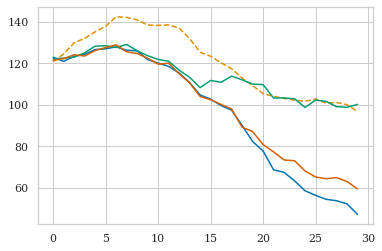

In [53]:
isst = 'CA'
# xx = np.array([statesales[iss] for iss in statesid if iss != isst])
xx = np.array([statesales[iss] for iss in statesid if iss in controlstates])
means = xx.mean(axis=0)
yy = statesales[isst]
xplot = np.arange(yy.size)
plt.plot(xplot, yy)
plt.plot(xplot, means, '--')

##
i = 0 
ncomp = tools.approximate_rank(xx - means, t=0.99)
ncomp = 10
print(ncomp)
pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center')
pca = pcl.pca
errpca = pca.get_covariance().diagonal()**0.5

pclT0 = pcalearn.PCAlearn(xx[:, :T0], ncomp, stdscale=False, normalization='center')
pcaT0 = pclT0.pca

##
ypcareg, ppreg = pcl.fit(yy.flatten(), T0, regwt=np.logspace(-4, -1, 100), verbose=True)
plt.plot(xplot, ypcareg)
ypca, pp = pcl.fit(yy.flatten(), T0, regwt=None, verbose=True)
plt.plot(xplot, ypca)
# plt.plot(xplot, ypcar, ":", lw=3, alpha=0.5)
# plt.plot(xplot, ypcar2, ':', lw=3, alpha=0.5)


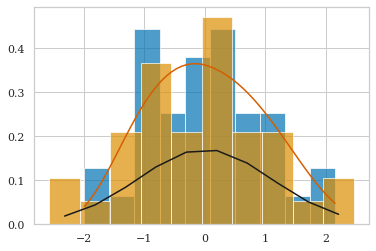

In [54]:
nbins=10
xxt = pca.transform(pcl.normalize(xx))
tt = xxt[:, 1].copy()
plt.hist(tt.flatten(), alpha=0.7, bins=nbins, density=True)
ptt = yjt.get_transform(tt)
# plt.plot(ttx, yjt.invtransform(ttx, ptt))
ttx = np.linspace(tt.min(), tt.max())
qq = yjt.getpdf(ttx, ptt)
plt.plot(ttx, qq, 'r')

y_, x_, _ = plt.hist(yjt.transform(tt,  ptt).flatten(), alpha=0.7, bins=nbins, density=True)
x_ = (x_[1:] + x_[:-1])/2.
pp = tools.fitgausspdf(yjt.transform(tt,  ptt).flatten(), normalized=True, verbose=0)    
plt.plot(x_, y_.max()*tools.logpdf_gauss(x_, *pp, rety=True), 'k')


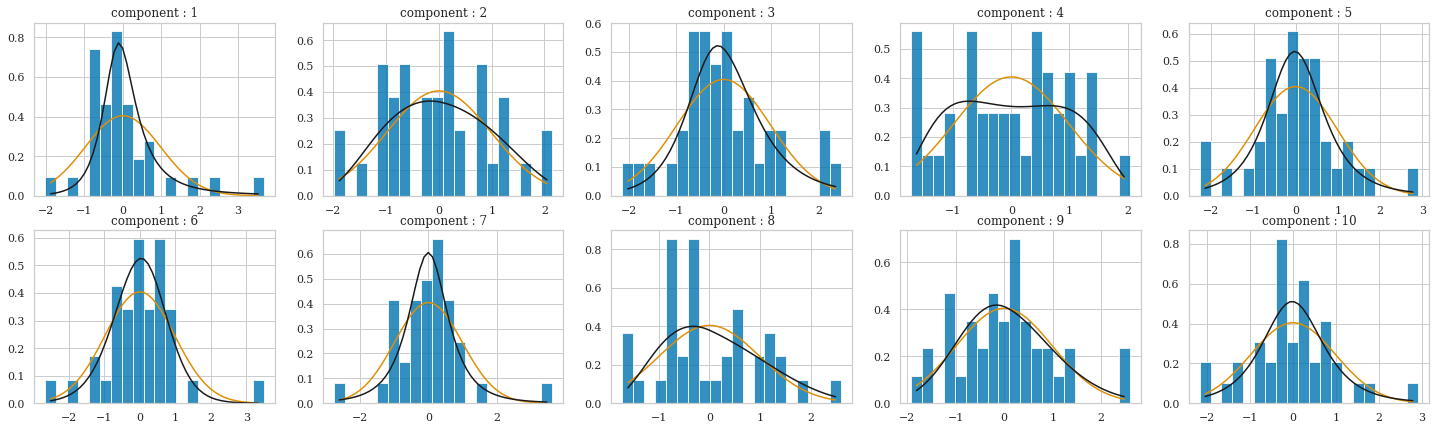

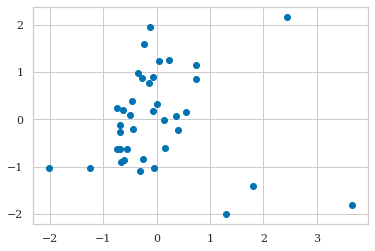

In [55]:
nbins = 20 
normed = True

# # ncomp = 10
# # xx = controls.copy()
# # pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center')
# # pca = pcl.pca
# xxt = pca.transform(pcl.normalize(xx))

fig, axar = plt.subplots(2, ncomp//2, figsize= (ncomp//2*5, 7))

ax = axar.flatten()
for ia in range(ncomp):
    y_, x_, _ = ax[ia].hist(xxt.T[ia], bins=nbins, density=normed, alpha=0.8)
    x_ = (x_[1:] + x_[:-1])/2.

    xplot = np.linspace(x_.min(), x_.max())
    ppg = tools.fitgausspdf(xxt.T[ia], normalized=True, verbose=0)    
    ax[ia].plot(xplot, tools.logpdf_gauss(xplot, *ppg, rety=True, normalized=True), 'C1')
    ax[ia].set_title("component : %d"%(ia+1))
    pyj = yjt.get_transform(xxt.T[ia])
    qq = yjt.getpdf(xplot, pyj)
    ax[ia].plot(xplot, qq, 'k')
    
plt.show()
plt.scatter(xxt[:, 0], xxt[:, 1])
plt.show()

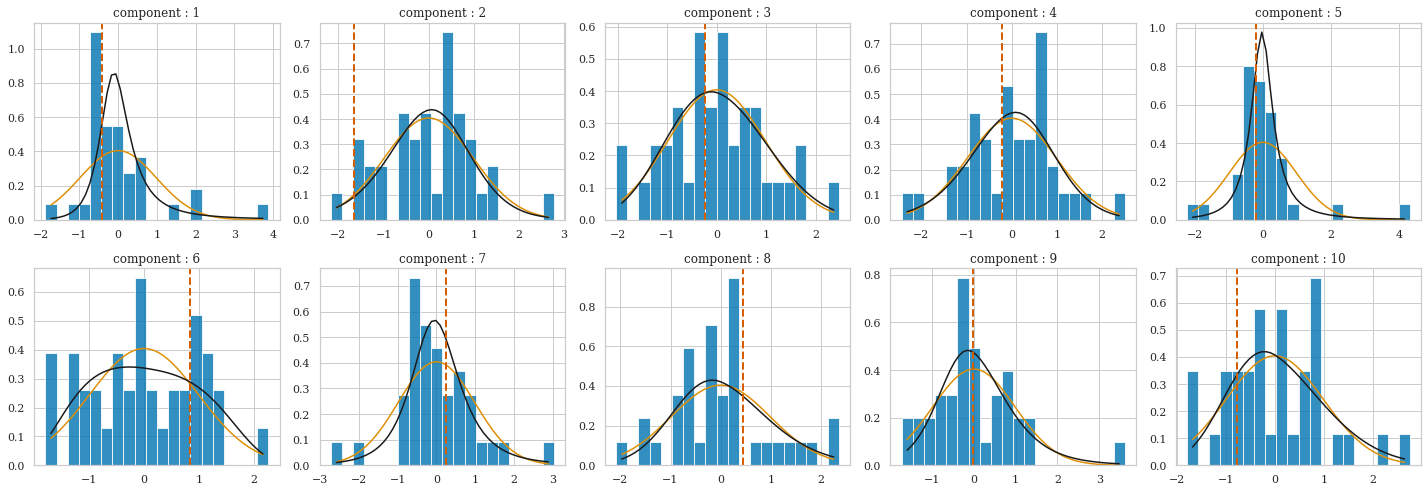

In [56]:
xxT0 = pcaT0.transform(pclT0.normalize(xx[:, :T0]))
ppT0 = pcaT0.transform(pclT0.normalize(treated[:T0]).reshape(1, -1))[0]

# fig, ax = plt.subplots(1, ncomp, figsize= (ncomp*4, 4))

# ppT0 = pcaT0.transform(treated[:T0].reshape(np.newaxis, 1))

fig, axar = plt.subplots(2, ncomp//2, figsize= (ncomp//2*4, 7))

ax = axar.flatten()
for ia in range(ncomp):
    y_, x_, _ = ax[ia].hist(xxT0.T[ia], bins=nbins, density=normed, alpha=0.8)
    x_ = (x_[1:] + x_[:-1])/2.

    xplot = np.linspace(x_.min(), x_.max())
    ppg = tools.fitgausspdf(xxT0.T[ia], normalized=True, verbose=0)    
    ax[ia].plot(xplot, tools.logpdf_gauss(xplot, *ppg, rety=True, normalized=True), 'C1')
    
    pyj = yjt.get_transform(xxT0.T[ia])
    qq = yjt.getpdf(xplot, pyj)
    ax[ia].plot(xplot, qq, 'k')
    
    ax[ia].axvline(ppT0[ia], color='r', lw=2, ls="--")
    ax[ia].set_title("component : %d"%(ia+1))

plt.tight_layout()
plt.show()

# fig, ax = plt.subplots(1, ncomp, figsize= (ncomp*4, 4))
# ax[0].scatter(xxT0[:, 0], xxT0[:, 1])
# ax[0].plot(ppT0[0], ppT0[1], 'rx', markersize=10, lw=2)
# ax[0].set_xlabel(0)
# ax[0].set_ylabel(1)

# ax[1].scatter(xxT0[:, 1], xxT0[:, 2])
# ax[1].plot(ppT0[1], ppT0[2], 'rx', markersize=10)
# ax[1].set_xlabel(1)
# ax[1].set_ylabel(2)

# ax[2].scatter(xxT0[:, 2], xxT0[:, 1])
# ax[2].plot(ppT0[2], ppT0[1], 'rx', markersize=10, lw=2)
# ax[2].set_ylabel(2)
# ax[2].set_xlabel(1)
# plt.tight_layout()
# plt.show()

In [57]:
class PCAYJ():
    
    def __init__(self, controls, n_components, stdscale=False, seed=100, normalization='center', whiten=True):

        self.T = controls.shape[1]
        self.seed = seed
        self.controls = controls
        self.means = controls.mean(axis=0)
        if stdscale: self.stds = controls.mean(axis=0)
        else : self.stds = 1
        self.cmin, self.cmax = self.controls.min(), self.controls.max()
        self.normalization = normalization
        self.controls_norm = self.normalize(self.controls)
        
        self.n_components = n_components
        self.pca = PCA(n_components=self.n_components, whiten=whiten)
        self.pca.fit(self.normalize(self.controls))
        self.cov = self.pca.get_covariance()
        self.icov = self.pca.get_precision()
        
        self.control_wts = self.pca.transform(self.controls_norm)
        self.pyj = []
        for i in range(self.n_components): self.pyj.append(yjt.get_transform(self.control_wts[:, i]))
        
    def normalize(self, x):
        if self.normalization is None: return x
        if self.normalization == 'center': return  (x - self.means)/self.stds
        elif self.normalization == 'minmax' :
            off, norm = (self.cmax+self.cmin)/2., (self.cmax-self.cmin)/2.
            return (x-off)/norm

    def unnormalize(self, y):
        if self.normalization is None: return y
        if self.normalization == 'center': return y * self.stds + self.means
        elif self.normalization == 'minmax' :
            off, norm = (self.cmax+self.cmin)/2., (self.cmax-self.cmin)/2.
            return y*norm + off


    def fit(self, treated, ols=True, verbose=False, method='lbfgs',):

        yy = self.normalize(treated.copy())

        def _chisq(p):
            #yp = self.pca.inverse_transform(p)                                                                                                                                 
            yp = np.dot(self.pca.components_.T, p) + self.pca.mean_
            diff = yy-yp
            diff[T0:] = 0
            chisq = np.sum(diff**2)
#             chisq = np.dot(np.dot(diff, self.icov), diff)
            return chisq
        
        def _logprior(p):
            reg = 0 
            for i in range(self.n_components): reg += np.log(yjt.getpdf(np.array(p[i]), self.pyj[i]))
            return reg
        
        def _loss(p):
            return _chisq(p) - _logprior(p)

        p0 = np.zeros(self.n_components)
        p0 = np.random.normal(size=self.n_components)
        
        if method == 'nelder-mead': pp = minimize(_loss, p0, method='Nelder-Mead', options={'maxiter':50000, 'maxfev':50000, 'tol':1e-10, 'rtol':1e-10})
        elif method == 'lbfgs' : pp = minimize(_loss, p0, method='L-BFGS-B', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})
        if verbose == 1: print(pp.fun)
        if verbose > 1: print(pp)
        if verbose >=1 : print(_chisq(pp.x), _logprior(pp.x))
        pp = pp.x
        yp = np.dot(self.pca.components_.T, pp) + self.pca.mean_
        #yp = self.pca.inverse_transform(pp)                                                                                                                                        
        yp = self.unnormalize(yp)
        return yp, pp





In [58]:
pcayj = PCAYJ(controls, 5, whiten=False)
# ty, tp = pcayj.fit(treated, T0, verbose=2, method='nelder-mead')
ty, tp = pcayj.fit(treated, T0, verbose=2, method='lbfgs')

      fun: 57.88410907041435
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00000000e+00, 3.55271368e-04, 7.10542736e-05, 2.84217094e-04,
       3.55271368e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 402
      nit: 32
   status: 0
  success: True
        x: array([-103.07158815,  -79.64249658,   -3.75878993,   -7.17610888,
          5.48822071])
34.14233692680814 -23.741772143606205


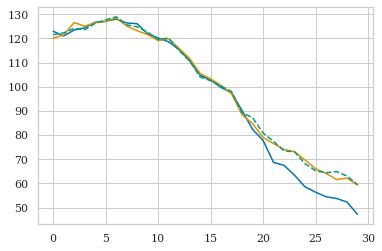

In [59]:
# plt.plot(means, 'gray')
plt.plot(treated)
plt.plot(ty)
plt.plot(ypca, '--')


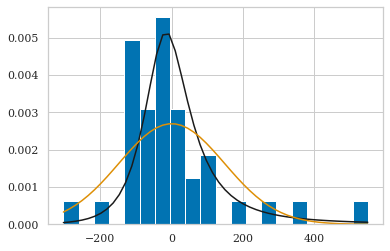

In [60]:
ii = 0
xdata = pcayj.control_wts[:, ii]
plt.hist(xdata, density=True, bins=20)
xplot = np.linspace( xdata.min(), xdata.max())
plt.plot(xplot, yjt.getpdf(xplot, pcayj.pyj[ii]), 'k')
ppg = tools.fitgausspdf(xdata)
plt.plot(xplot, tools.logpdf_gauss(xplot, *ppg, rety=True))
# plt.plot(xplot, yjt.getpdf(xplot, pcayj.pyj[ii]))

# a Placebo study

In [ ]:

class GetObject(object):
    def __init__(self, *initial_data, **kwargs):
        for dictionary in initial_data:
            for key in dictionary:
                setattr(self, key, dictionary[key])
        for key in kwargs:
            setattr(self, key, kwargs[key])

            
xplot = years.copy()            


In [ ]:
ncpca = tools.approximate_rank(controls-means, t=0.99)
print("rank = ", ncpca)


statepcafits = {}

# for ss in ['CA']:
for issn, ss in enumerate(statesid):
    
    xx = np.array([statesales[iss] for iss in statesid if (iss !=ss) & (iss in controlstates)])
#     xx = np.array([statesales[iss] for iss in statesid if  iss is not in controlstates])
    means = xx.mean(axis=0)
    yy = statesales[ss]
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center')
    ##
    ypca2, pp2 = pcl.fit(yy.flatten(), T0, ols=True, regwt=None, verbose=False)
#     ypca2, pp2 = pcl.fit(yy.flatten(), T0, ols=True, regwt=np.logspace(-4, 0, 50), verbose=False)
    
#     statepcafits2[ss] = GetObject(controls=xx, treated=yy, pcl=pcl, pred=ypca, predols=ypca2, fitp=pp, fitpols=pp2)
    statepcafits[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2)


statepcafitsyj = {}

# for ss in ['CA']:
for issn, ss in enumerate(statesid):
    
    xx = np.array([statesales[iss] for iss in statesid if (iss !=ss) & (iss in controlstates)])
#     xx = np.array([statesales[iss] for iss in statesid if  iss is not in controlstates])
    means = xx.mean(axis=0)
    yy = statesales[ss]
    ##
    pcl = PCAYJ(xx, ncpca, stdscale=False, normalization='center', whiten=False)
    ##
    ypca2, pp2 = pcl.fit(yy.flatten(), T0)
    
    statepcafitsyj[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2)



In [ ]:
ncpca3 = 3


statepcafits3 = {}

# for ss in ['CA']:
for issn, ss in enumerate(statesid):
    
    xx = np.array([statesales[iss] for iss in statesid if (iss !=ss) & (iss in controlstates)])
#     xx = np.array([statesales[iss] for iss in statesid if  iss is not in controlstates])
    means = xx.mean(axis=0)
    yy = statesales[ss]
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca3, stdscale=False, normalization='center')
    ##
    ypca2, pp2 = pcl.fit(yy.flatten(), T0, ols=True, regwt=None, verbose=False)
    statepcafits3[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2)


statepcafitsyj3 = {}

# for ss in ['CA']:
for issn, ss in enumerate(statesid):
    
    xx = np.array([statesales[iss] for iss in statesid if (iss !=ss) & (iss in controlstates)])
#     xx = np.array([statesales[iss] for iss in statesid if  iss is not in controlstates])
    means = xx.mean(axis=0)
    yy = statesales[ss]
    ##
    pcl = PCAYJ(xx, ncpca3, stdscale=False, normalization='center', whiten=False)
    ##
    ypca2, pp2 = pcl.fit(yy.flatten(), T0)
    
    statepcafitsyj3[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2)



In [ ]:
statesvdfitsc = {}

# for ss in ['CA']:
for issn, ss in enumerate(statesid):    
    xx = np.array([statesales[iss] for iss in statesid if (iss !=ss) & (iss in controlstates)])
#     xx = np.array([statesales[iss] for iss in statesid if  iss is not in controlstates])
    means = xx.mean(axis=0)
    yy = statesales[ss]
    ##
    svl = SVDlearn(xx, stdscale=False, normalization='center')
    yp, pp = svl.fit(yy.flatten(), T0, ncpca, verbose=False)
    statesvdfitsc[ss] = GetObject(controls=xx, treated=yy, svl=svl, pred=yp, fitp=pp)

statesvdfitsc3 = {}

# for ss in ['CA']:
for issn, ss in enumerate(statesid):    
    xx = np.array([statesales[iss] for iss in statesid if (iss !=ss) & (iss in controlstates)])
#     xx = np.array([statesales[iss] for iss in statesid if  iss is not in controlstates])
    means = xx.mean(axis=0)
    yy = statesales[ss]
    ##
    svl = SVDlearn(xx, stdscale=False, normalization='center')
    yp, pp = svl.fit(yy.flatten(), T0, ncpca3, verbose=False)
    statesvdfitsc3[ss] = GetObject(controls=xx, treated=yy, svl=svl, pred=yp, fitp=pp)
    
    
ncsvd = tools.approximate_rank(controls, t=0.99)
# if ncsvd <3: ncsvd = 3
statesvdfits = {}

for issn, ss in enumerate(statesid):
    xx = np.array([statesales[iss] for iss in statesid if (iss !=ss) & (iss in controlstates)])
#     xx = np.array([statesales[iss] for iss in statesid if  iss is not in controlstates])
    yy = statesales[ss]
    ##
    svl = SVDlearn(xx, stdscale=False, normalization=None)
    yp, pp = svl.fit(yy.flatten(), T0, ncsvd, verbose=False)
    statesvdfits[ss] = GetObject(controls=xx, treated=yy, svl=svl, pred=yp, fitp=pp)



In [ ]:

stateshsvt =  {}
for issn, ss in enumerate(statesid):    
    xx = np.array([statesales[iss] for iss in statesid if (iss !=ss) & (iss in controlstates)])
    means = xx.mean(axis=0)
    yy = statesales[ss]
    ##
    yp, wts = hsvt_fit(xx, yy, T0, t=0.999)
       
    stateshsvt[ss] = GetObject(controls=xx, treated=yy, pred=yp, wts=wts)


In [ ]:

def get_ykde(gg, X1, X2, Y1, means, gamma=np.logspace(-3, 1, 1000), caty1=True):
    kde = KernelRegression(gg, gamma=gamma)
    kde.fit(X1, X2)
    if len(Y1.shape) <=1: Y1 =  Y1.reshape(1,-1)
    ykde, wts = kde.predict(Y1, retK=True)
    ykde0 = kde.predict(Y1, X1, retK=False)
    ykde = ykde.flatten()
    ykde0 = ykde0.flatten()
    if caty1 == 1: ykde = np.concatenate([Y1.flatten(), ykde]) + means
    elif caty1 == 2: ykde = np.concatenate([ykde0, ykde]) + means
    return ykde, kde, wts


stateskde =  {}
# for ss in ['CA']:
for issn, ss in enumerate(statesid):    
    xx = np.array([statesales[iss] for iss in statesid if (iss !=ss) & (iss in controlstates)])
    means = xx.mean(axis=0)
    yy = statesales[ss]
    ##
    X1 = (xx - means)[:, :T0]
    X2 = (xx - means)[:, T0:]
    Y1 = (yy-means)[:T0]
    Y2 = (yy-means)[T0:]
    yp, kde, wts = get_ykde('rbf', X1, X2, Y1, means, caty1=2)
        
    stateskde[ss] = GetObject(controls=xx, treated=yy, kde=kde, pred=yp, wts=wts)

    
stateskdepca =  {}
# for ss in ['CA']:
for issn, ss in enumerate(statesid):    
    xx = np.array([statesales[iss] for iss in statesid if (iss !=ss) & (iss in controlstates)])
    means = xx.mean(axis=0)
    yy = statesales[ss]
    ##
    X1 = (xx - means)[:, :T0]
    X2 = (xx - means)[:, T0:]
    Y1 = (yy-means)[:T0]
    Y2 = (yy-means)[T0:]
    nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
    if nc1 <=1 : nc1 +=1 
    if nc2 <=1 : nc2 +=1 
    p1, p2 = PCA(nc1, whiten=True).fit(X1), PCA(nc2, whiten=True).fit(X2)
    XX1, XX2 = p1.transform(X1), p2.transform(X2)
    YY1 = p1.transform(Y1.reshape(1,-1))
    ykdep, kde, wts = get_ykde('rbf', XX1, XX2, YY1, means=0, caty1=2)
    y1, y2 = ykdep[:nc1], ykdep[nc1:]
    yp = np.concatenate([p1.inverse_transform(y1), p2.inverse_transform(y2)]) + means
        
    stateskdepca[ss] = GetObject(controls=xx, treated=yy, kde=kde, pred=yp, wts=wts)

    
    
    
stateskdepca3 =  {}
# for ss in ['CA']:
for issn, ss in enumerate(statesid):    
    xx = np.array([statesales[iss] for iss in statesid if (iss !=ss) & (iss in controlstates)])
    means = xx.mean(axis=0)
    yy = statesales[ss]
    ##
    X1 = (xx - means)[:, :T0]
    X2 = (xx - means)[:, T0:]
    Y1 = (yy-means)[:T0]
    Y2 = (yy-means)[T0:]
    nc1, nc2 = 3, 3 # tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
    if nc1 <=1 : nc1 +=1 
    if nc2 <=1 : nc2 +=1 
    p1, p2 = PCA(nc1, whiten=True).fit(X1), PCA(nc2, whiten=True).fit(X2)
    XX1, XX2 = p1.transform(X1), p2.transform(X2)
    YY1 = p1.transform(Y1.reshape(1,-1))
    ykdep, kde, wts = get_ykde('rbf', XX1, XX2, YY1, means=0, caty1=2)
    y1, y2 = ykdep[:nc1], ykdep[nc1:]
    yp = np.concatenate([p1.inverse_transform(y1), p2.inverse_transform(y2)]) + means
        
    stateskdepca3[ss] = GetObject(controls=xx, treated=yy, kde=kde, pred=yp, wts=wts)
    

In [ ]:

    
statesgp, statesgppca, statesgppca3  =  {}, {}, {}
# for ss in ['CA']:
for issn, ss in enumerate(statesid):    
    xxc = np.array([statesales[iss] for iss in statesid if (iss !=ss) & (iss in controlstates)])
    yyc = statesales[ss]    
    means = xxc.mean(axis=0)*1
    stds = xxc.std(axis=0)*1 # + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds

    xxp = xx.copy()
    gp = GPR(kernels.RBF(0.1), n_restarts_optimizer=100).fit(xxp[:, :T0], xxp[:, T0:])
    yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1)))
    ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
    yp = np.append(yyc[:T0], yp*stds[T0:] + means[T0:])
    ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
    ysample = ysample.T*stds[T0:]
    err = np.append(np.zeros(T0), ysample.std(axis=0))
    statesgp[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err)

    nc = tools.approximate_rank(xx-xx.mean(axis=0))
    pca =  PCA(nc).fit(xx)
    xxp = pca.inverse_transform(pca.transform(xx))
    alpha = (xx - xxp).std(axis=1)
    gp = GPR(kernels.RBF(0.1), n_restarts_optimizer=100, alpha=alpha).fit(xxp[:, :T0], xxp[:, T0:])
    yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1)))
    yp = np.append(yyc[:T0], yp*stds[T0:] + means[T0:])
    ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
    ysample = ysample.T*stds[T0:]
    err = np.append(np.zeros(T0), ysample.std(axis=0))
    statesgppca[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, pca=pca)

    
    nc = 3
    pca =  PCA(nc).fit(xx)
    xxp = pca.inverse_transform(pca.transform(xx))
    alpha = (xx - xxp).std(axis=1)
    gp = GPR(kernels.RBF(0.1), n_restarts_optimizer=100, alpha=alpha).fit(xxp[:, :T0], xxp[:, T0:])
    yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1)))
    yp = np.append(yyc[:T0], yp*stds[T0:] + means[T0:])
    ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
    ysample = ysample.T*stds[T0:]
    err = np.append(np.zeros(T0), ysample.std(axis=0))
    statesgppca3[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, pca=pca)

    
    
# statesgp, statesgppca, statesgppca3  =  {}, {}, {}
# # for ss in ['CA']:
# for issn, ss in enumerate(statesid):    
#     xxc = np.array([statesales[iss] for iss in statesid if (iss !=ss) & (iss in controlstates)])
#     yyc = statesales[ss]    
#     means = xxc.mean(axis=0)*0
#     stds = xxc.std(axis=0)*0 + 1
#     xx = (xxc - means)/stds
#     yy = (yyc - means)/stds

#     xxp = xx.copy()
#     gp = GPR(kernels.RBF(1), n_restarts_optimizer=10).fit(xxp[:, :T0], xxp[:, T0:])
#     yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1)))
#     ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
#     yp = np.append(yyc[:T0], yp*stds[T0:] + means[T0:])
#     err = np.append(np.zeros(T0), ysample.std(axis=1))
#     statesgp[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=ysample.std(axis=1))

#     nc = tools.approximate_rank(xx-xx.mean(axis=0))
#     pca =  PCA(nc).fit(xx)
#     xxp = pca.inverse_transform(pca.transform(xx))
#     gp = GPR(kernels.RBF(1), n_restarts_optimizer=10).fit(xxp[:, :T0], xxp[:, T0:])
#     yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1)))
#     ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
#     yp = np.append(yyc[:T0], yp*stds[T0:] + means[T0:])
#     err = np.append(np.zeros(T0), ysample.std(axis=1))
#     statesgppca[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=ysample.std(axis=1), pca=pca)

    
#     nc = 3
#     pca =  PCA(nc).fit(xx)
#     xxp = pca.inverse_transform(pca.transform(xx))
#     gp = GPR(kernels.RBF(1), n_restarts_optimizer=10).fit(xxp[:, :T0], xxp[:, T0:])
#     yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1)))
#     ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
#     yp = np.append(yyc[:T0], yp*stds[T0:] + means[T0:])
#     err = np.append(np.zeros(T0), ysample.std(axis=1))
#     statesgppca3[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=ysample.std(axis=1), pca=pca)
    


In [ ]:
    
statesgpindep  =  {}
# for ss in ['CA']:
for issn, ss in enumerate(statesid):    
    xxc = np.array([statesales[iss] for iss in statesid if (iss !=ss) & (iss in controlstates)])
    yyc = statesales[ss]    
    means = xxc.mean(axis=0)*1
    stds = xxc.std(axis=0)*1 # + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds

    gps, yps, errs = [], [], []
    for tt in range(T0, xx.shape[1]):
        gp = GPR(kernels.RBF(0.01), n_restarts_optimizer=100).fit(xxp[:, :T0], xxp[:, tt])
        yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1))) * stds[tt] + means[tt]
        ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100)).T * stds[tt] + means[tt]
        ystd = ysample.std(axis=0)
        plt.errorbar(years[tt], yp, ystd, color='C1', marker='o')

        gp = GPR(kernels.RBF(1.*np.ones_like(yy[:T0]), length_scale_bounds=(1e-3, 10)), n_restarts_optimizer=100).fit(xxp[:, :T0], xxp[:, tt])
        yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1))) * stds[tt] + means[tt]
        ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100)).T * stds[tt] + means[tt]
        ystd = ysample.std(axis=0)
        yps.append(yp)
        errs.append(ystd)
        gps.append(gp)
    yp = np.append(yyc[:T0], yps)
    err = np.append(np.zeros(T0), errs)
    statesgpindep[ss] = GetObject(controls=xxc, treated=yyc, gp=gps, pred=yp, err=err)

#     plt.errorbar(years[tt], yp, ystd, color='C3', marker='v')

#     plt.fill_between(years[T0:], yp-ystd, yp+ystd, color= 'C0', alpha=0.2);


## Plot

In [ ]:
# irs = np.sort(np.random.permutation(np.arange(len(controlstates)))[:19])
nrow =  5
ncol = 5
irs = np.sort(np.random.permutation(np.arange(len(statesid)))[:nrow*ncol-1])
if sil['NH'] in irs: pass
else: irs = np.append(irs[:-1], sil['NH'])
if sil['UT'] in irs: pass
else: irs = np.append(irs[:-1], sil['UT'])
fig, axar = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*3.2),
                         sharex=True, sharey=True)
ax = axar.flatten()

for jj, ir in enumerate(irs):
    ii = jj + 1
    ss = statesid[ir]
    xx = statepcafits[ss].controls
    means, stds = xx.mean(axis=0), xx.std(axis=0)
    yy = statepcafits[ss].treated
    
    ax[ii].plot(years, means, 'k--')
    ax[ii].fill_between(years, means-stds, means+stds, color='gray', alpha=0.2)
#     ax[ii].plot(years, statesales[ss], 'r--', lw=3, alpha=0.8)
    ax[ii].plot(years, yy, 'k')
    ax[ii].plot(years, statesscm[ss].pred, 'k--')
    ax[ii].plot(years, stateshsvt[ss].pred, 'k:')

    ax[ii].plot(years, statepcafits[ss].pred, 'C0-')
    ax[ii].plot(years, statepcafits3[ss].pred, 'C0--')
    ax[ii].plot(years, statepcafitsyj[ss].pred, 'C1-')
    ax[ii].plot(years, statepcafitsyj3[ss].pred, 'C1--')
    
    ax[ii].plot(years, statesvdfits[ss].pred, 'C3-')
    ax[ii].plot(years, statesvdfitsc[ss].pred, 'C3--')
    ax[ii].plot(years, statesvdfitsc3[ss].pred, 'C3:', lw=2)
    
    ax[ii].plot(years, stateskde[ss].pred, 'C4-')
    ax[ii].plot(years, stateskdepca[ss].pred, 'C4--')
    ax[ii].plot(years, stateskdepca3[ss].pred, 'C4:', lw=2)

    ax[ii].plot(years, statesgp[ss].pred, 'C7-')
    ax[ii].plot(years, statesgppca[ss].pred, 'C7--')
    ax[ii].plot(years, statesgppca3[ss].pred, 'C7:', lw=2)
    ax[ii].set_title(ss, fontsize=12)
    
ss = 'CA'
ii=0
xx = statepcafits[ss].controls
means, stds = xx.mean(axis=0), xx.std(axis=0)
yy = statepcafits[ss].treated
yp = synth.fit(xx, yy, T0)[0]

ax[ii].plot(years, means, 'k--')
ax[ii].fill_between(years, means-stds, means+stds, color='gray', alpha=0.2)
ax[ii].plot(years, yy, 'k', label='Data')
ax[ii].plot(years, statesscm[ss].pred, 'k--', label='SCM')
ax[ii].plot(years, stateshsvt[ss].pred, 'k:', label='HSVT')
ax[ii].plot(years, statepcafits[ss].pred, 'C0-', label='PCA')
ax[ii].plot(years, statepcafits3[ss].pred, 'C0--', label='PCA3')
ax[ii].plot(years, statepcafitsyj[ss].pred, 'C1-', label='PCA-YJ')
ax[ii].plot(years, statepcafitsyj3[ss].pred, 'C1--', label='PCA-YJ3')
ax[ii].plot(years, statesvdfits[ss].pred, 'C3-', label='SVD')
ax[ii].plot(years, statesvdfitsc[ss].pred, 'C3--', label='SVD-C')
ax[ii].plot(years, statesvdfitsc[ss].pred, 'C3:', label='SVD-C3')
ax[ii].plot(years, stateskde[ss].pred, 'C4-', label='KDE')
ax[ii].plot(years, stateskdepca[ss].pred, 'C4--', label='KDE-PCA')
ax[ii].plot(years, stateskdepca3[ss].pred, 'C4:', label='KDE-PCA3')
ax[ii].plot(years, statesgp[ss].pred, 'C7-', label='GP')
ax[ii].plot(years, statesgppca[ss].pred, 'C7--', label='GP-PCA')
ax[ii].plot(years, statesgppca3[ss].pred, 'C7:', label='GP-PCA3', lw=2)
ax[ii].set_title(ss, fontsize=12)
ax[ii].legend(ncol=8, fontsize=13, loc=3, bbox_to_anchor=(0, 1.05))

for axis in ax:
    axis.set_xlim(1969, 2005)
    axis.set_ylim(25, 200)
    axis.axvline(1988, color='c', ls='--')
#     ax[0].legend(ncol=6, bbox_to_anchor=(4.5, 1.3), fontsize=12)

In [ ]:
# for ss in statesid:
for ss in ['NH']:
    w1, w2 = stateskde[ss].wts.flatten(), statesscm[ss].wts.flatten()
    w1 /= w1.sum()
    w2 /= w2.sum()
    w1[w1<0.01] = 0
    w2[w2<0.01] = 0
    print(ss, np.corrcoef(w1, w2)[0, 1])
#     plt.plot(w1, w2, '.')
#     plt.show()
    fig, ax = plt.subplots(1,1, figsize=(8, 5))
    ax = [ax]
    ii=0
    ax[ii].plot(years, statesscm[ss].controls.mean(axis=0), 'k:',lw=2)
    ax[ii].plot(years, statesscm[ss].treated, 'k',lw=2)
    ax[ii].plot(years, statesscm[ss].pred, 'k-.', label='SCM')
    ax[ii].plot(years, statesvdfits[ss].pred, 'C0-', label='SVD')
    ax[ii].plot(years, statesvdfitsc[ss].pred, 'C0--', lw=2, label='SVD-C')
    ax[ii].plot(years, statesvdfitsc3[ss].pred, 'C0:', lw=2, label='SVD-C3')
    ax[ii].plot(years, stateskde[ss].pred, 'C1-', label='KDE')
    ax[ii].plot(years, stateskdepca[ss].pred, 'C1--', label='KDE-PCA')
    ax[ii].plot(years, stateskdepca3[ss].pred, 'C1:', label='KDE-PCA3')
    

    ax[ii].plot(years, statepcafits[ss].pred, 'C2', label='PCA')
    ax[ii].plot(years, statepcafits3[ss].pred, 'C2--', label='PCA-3')
    ax[ii].plot(years, statepcafitsyj[ss].pred, 'C4', label='PCA-YJ')
    ax[ii].plot(years, statepcafitsyj3[ss].pred, 'C4--', label='PCA-YJ-3')
    ax[ii].errorbar(years, statesgp[ss].pred, statesgp[ss].err, color='C7', label='GP', elinewidth=0.5)
    ax[ii].errorbar(years+0.25, statesgppca[ss].pred, statesgppca[ss].err, color='C9', ls="-", lw=1, elinewidth=0.5, label='GP-PCA')
    ax[ii].errorbar(years-0.25, statesgppca3[ss].pred, statesgppca3[ss].err, color='C9', ls="--",  lw=2, elinewidth=0.5, label='GP-PCA3')

plt.legend()
plt.xlim(1970, 2005)
# plt.ylim(0, 200)

In [ ]:
diffscm, diffhsvt  = np.zeros_like(controls), np.zeros_like(controls)
diffsvd, diffsvdc, diffsvdc3  = np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls)
diffkde, diffkdepca, diffkdepca3 = np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls)
diffpca, diffpca3, diffpcayj, diffpcayj3 = np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls)
diffgp, diffgppca, diffgppca3 = np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls)
diffgpindep = np.zeros_like(controls)
# for ii, ss in enumerate(statesid):
for ii, ss in enumerate(controlstates):
    xx = statepcafits[ss].controls
    means, stds = xx.mean(axis=0), xx.std(axis=0)
    yy = statepcafits[ss].treated
#     yp = synth.fit(xx, yy, T0)[0]

    diffscm[ii] = (yy-statesscm[ss].pred)
    diffhsvt[ii] = (yy-stateshsvt[ss].pred)

    diffpca[ii] = (yy-statepcafits[ss].pred)
    diffpcayj[ii] = (yy-statepcafitsyj[ss].pred)    
    diffpca3[ii] = (yy-statepcafits3[ss].pred)
    diffpcayj3[ii] = (yy-statepcafitsyj3[ss].pred)
    
    diffsvd[ii] = (yy-statesvdfits[ss].pred)
    diffsvdc[ii] = (yy-statesvdfitsc[ss].pred)
    diffsvdc3[ii] = (yy-statesvdfitsc3[ss].pred)
    
    diffkde[ii] = (yy-stateskde[ss].pred)
    diffkdepca[ii] = (yy-stateskdepca[ss].pred)
    diffkdepca3[ii] = (yy-stateskdepca3[ss].pred)
    
    diffgp[ii] = (yy-statesgp[ss].pred)
    diffgppca[ii] = (yy-statesgppca[ss].pred)
    diffgppca3[ii] = (yy-statesgppca3[ss].pred)
    diffgpindep[ii] = (yy-statesgpindep[ss].pred)


In [ ]:



# tmppca = statepcafits['CA']
# tmpx = statepcafits['CA'].controls
tmpy = statepcafits['CA'].treated

fig, axar = plt.subplots(3, 5, figsize=(20, 14), sharex=True, sharey=True)
ax = axar.flatten()

dd = diffscm.copy()
ax[0].plot(years, dd.T, 'C0-', alpha=0.5)
ax[0].plot(years, dd.mean(axis=0), 'C1', alpha=0.5)
ax[0].fill_between(years, dd.mean(axis=0) - dd.std(axis=0), dd.mean(axis=0) + dd.std(axis=0), color='C1', alpha=0.5)
ax[0].plot(years, tmpy - statesscm['CA'].pred, 'k-', alpha=1)
ax[0].set_title('SCM')
ax[0].set_ylabel("Data - Pred")


def tmpplot(ii, title, dd, ddca):
    ax[ii].plot(years, dd.T, 'C0-', alpha=0.5)
    ax[ii].plot(years, dd.mean(axis=0), 'C1', alpha=0.5)
    ax[ii].fill_between(years, dd.mean(axis=0) - dd.std(axis=0), dd.mean(axis=0) + dd.std(axis=0), color='C2', alpha=0.5)
    ax[ii].plot(years, tmpy - ddca, 'k-', alpha=1)
    ax[ii].set_title(title)


ii, title, dd, ddca = 1, 'SVD', diffsvd.copy(), statesvdfits['CA'].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 2, 'SVD-center', diffsvdc.copy(), statesvdfitsc['CA'].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 3, 'SVD-center3', diffsvdc3.copy(), statesvdfitsc3['CA'].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 4, 'KDE', diffkde.copy(), stateskde['CA'].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 5, 'KDE-PCA', diffkdepca.copy(), stateskdepca['CA'].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 6, 'KDE-PCA3', diffkdepca3.copy(), stateskdepca3['CA'].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 7, 'PCA', diffpca.copy(), statepcafits['CA'].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 8, 'PCA-YJ', diffpcayj.copy(), statepcafitsyj['CA'].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 9, 'PCA-3', diffpca3.copy(), statepcafits3['CA'].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 10, 'PCA-YJ3', diffpcayj3.copy(), statepcafitsyj3['CA'].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 11, 'GP', diffgp.copy(), statesgp['CA'].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 12, 'GP-PCA', diffgppca.copy(), statesgppca['CA'].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 13, 'GP-PCA3', diffgppca3.copy(), statesgppca3['CA'].pred
tmpplot(ii, title, dd, ddca)

# ii, title, dd, ddca = 14, 'HSVT', diffhsvt.copy(), stateshsvt['CA'].pred
# tmpplot(ii, title, dd, ddca)
ii, title, dd, ddca = 14, 'GP-indep', diffgpindep.copy(), statesgpindep['CA'].pred
tmpplot(ii, title, dd, ddca)

for axis in ax:
    axis.set_xlim(1969, 2005)
    axis.set_ylim(-75, 75)
    axis.axvline(1988, color='c', ls='--')


In [ ]:
# ##Check that PCA and SVD give same result when no regularization is imposed
# pcl = pcalearn.PCAlearn(controls, 2, normalization='center')
# svl = SVDlearn(controls, normalization='center')
# testpc = pcl.fit(treated, T0, regwt=0)
# testsv = svl.fit(treated, T0, 2)
# plt.plot(statepcafits2['CA'].predols)
# plt.plot(testpc[0])
# plt.plot(testsv[0], '--')

In [ ]:
# np.dot(np.dot(u[:, :nc], np.diag(s[:nc])), vh[:nc])
# pca.inverse_transform(pca.transform(xx))

In [ ]:
# xx = (controls - means)[:, :T0]
# pca = PCA(5).fit(xx)
# yy = (treated - means)[:T0]
# bb = np.linalg.pinv(pca.inverse_transform(pca.transform(xx)).T).dot(yy)
# bb2 = np.linalg.pinv(pca.transform(xx).T).dot(pca.transform(yy.reshape(1, -1)).flatten())
# # xx.shape, yy.shape



## SCM weights and kernel

In [ ]:
xx = controls.copy()
yy = treated.copy()
means = xx.mean(axis=0)
xxt, yyt = xx[:, :T0], yy[:T0]
yy2d = yy.reshape(1,-1)
yyt2d = yyt.reshape(1,-1)

xxc = xx - means
yyc = yy - means
xxtc, yytc = xxc[:, :T0], yyc[:T0]
yyc2d = yyc.reshape(1,-1)
yytc2d = yytc.reshape(1,-1)


thresh = 0.99
ncomp0 = tools.approximate_rank(xx, t=thresh)
ncompc = tools.approximate_rank(xxc, t=thresh)
ncompt = tools.approximate_rank(xxt, t=thresh+0.009)
ncomptc = tools.approximate_rank(xxtc, t=thresh)
print(ncomp0, ncompc, ncompt, ncomptc)

sv0 = SVDlearn(xx, normalization=None)
ysv0, psv0 =  sv0.fit(yy, T0, n_components=ncomp0)
svc = SVDlearn(xx, normalization='center')
ysvc, psvc =  svc.fit(yy, T0, n_components=ncompc)


rscm0 = RSCM(xx, ncomp0, normalization=None)
yrscm0, prscm0 = rscm0.fit(yy, T0, )
yrscm0reg, prscm0reg = rscm0.fit(yy, T0, regwt=np.logspace(-2, 3), regularization = 'l2', dT=2)
rscmc = RSCM(xx, ncompc, normalization='center')
yrscmc, prscmc = rscmc.fit(yy, T0, )
yrscmcreg, prscmcreg = rscmc.fit(yy, T0, regwt=np.logspace(-2, 3), regularization = 'l2', dT=2)

rscmt = RSCM(xxt, ncompt, normalization=None)
yrscmt, prscmt = rscmt.fit(yyt, T0, )
yrscmtreg, prscmtreg = rscmt.fit(yyt, T0, regwt=np.logspace(-2, 3), regularization = 'l2', dT=2)
rscmtc = RSCM(xxt, ncomptc, normalization='center')
yrscmtc, prscmtc = rscmtc.fit(yyt, T0, )
yrscmtcreg, prscmtcreg = rscmtc.fit(yyt, T0, regwt=np.logspace(-2, 3), regularization = 'l2', dT=2)
#

yscm, wscm = synth.fit(xx, yy, T0)
yscmc, wscmc = synth.fit(xxc, yyc, T0)
yscmc += means

In [ ]:
plt.plot(years, treated, 'k')
plt.plot(years, yrscm0, 'C0')
plt.plot(years, yrscmc, 'C0--', lw=2, alpha=0.7)
plt.plot(years, ysv0, 'C1')
plt.plot(years, ysvc, 'C1--', lw=2, alpha=0.7)
plt.plot(years, yrscm0reg, 'C3')
plt.plot(years, yrscmcreg, 'C3--', lw=2, alpha=0.7)
plt.plot(years, yscm, 'C4')
plt.plot(years, yscmc, 'C4--', lw=2, alpha=0.7)
plt.xlim(1970, 2005)

In [ ]:
ss = np.linalg.svd(xx, compute_uv=None)
sst = np.linalg.svd(xxt, compute_uv=None)
ssc = np.linalg.svd(xxc, compute_uv=None)
sstc = np.linalg.svd(xxtc, compute_uv=None)

plt.plot(np.cumsum(ss**2)/(ss**2).sum(), 'o', label='data')
plt.plot(np.cumsum(sst**2)/(sst**2).sum(), 'x', label='data T0')
plt.plot(np.cumsum(ssc**2)/(ssc**2).sum(), 'v', label='center')
plt.plot(np.cumsum(sstc**2)/(sstc**2).sum(), '^', label='center T0')
plt.legend()
plt.xlim(-1, 10)
plt.axhline(0.99, lw=0.5, color='gray')

In [ ]:
pca0 = PCA(ncomp0).fit(xx)
pp0 = pca0.transform(xx)
yp0 = pca0.transform(yy2d)

pcat = PCA(ncompt).fit(xxt)
ppt = pcat.transform(xxt)
ypt = pcat.transform(yyt2d)

pcac = PCA(ncompc).fit(xxc)
ppc = pcac.transform(xxc)
ypc = pcac.transform(yyc2d)

pcatc = PCA(ncomptc).fit(xxtc)
pptc = pcatc.transform(xxtc)
yptc = pcatc.transform(yytc2d)


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

axx = ax[0]
pp, yp = pp0, yp0

l2 = (abs(pp - yp)**2).sum(axis=1)**0.5
l2 /= l2.max()
l2 = np.exp(-l2)
cos = np.dot(pp , yp.T).flatten()/(pp**2).sum(axis=1)**0.5/(yp**2).sum()**0.5

bb = prscm0.copy()
axx.plot(bb, l2, 'o', label='l2, r=%0.2f'%(np.corrcoef(bb, l2)[0, 1]))
axx.plot(bb, cos, 'x', label='cos, r=%0.2f'%(np.corrcoef(bb, cos)[0, 1]))

bb = prscm0reg.copy()
axx.plot(bb, l2, 'v', label='reg-l2, r=%0.2f'%(np.corrcoef(bb, l2)[0, 1]))
axx.plot(bb, cos, '^', label='reg-cos, r=%0.2f'%(np.corrcoef(bb, cos)[0, 1]))
axx.legend(ncol=2, loc=4, bbox_to_anchor=(1, 1))


axx = ax[1]
pp, yp = ppt, ypt

l2 = (abs(pp - yp)**2).sum(axis=1)**0.5
l2 /= l2.max()
l2 = np.exp(-l2)
cos = np.dot(pp , yp.T).flatten()/(pp**2).sum(axis=1)**0.5/(yp**2).sum()**0.5

bb = prscmt.copy()
axx.plot(bb, l2, 'o', label='l2, r=%0.2f'%(np.corrcoef(bb, l2)[0, 1]))
axx.plot(bb, cos, 'x', label='cos, r=%0.2f'%(np.corrcoef(bb, cos)[0, 1]))

bb = prscmtreg.copy()
axx.plot(bb, l2, 'v', label='reg-l2, r=%0.2f'%(np.corrcoef(bb, l2)[0, 1]))
axx.plot(bb, cos, '^', label='reg-cos, r=%0.2f'%(np.corrcoef(bb, cos)[0, 1]))
axx.legend(ncol=2, loc=4, bbox_to_anchor=(1, 1))



plt.show()



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

axx = ax[0]
pp, yp = ppc, ypc

l2 = (abs(pp - yp)**2).sum(axis=1)**0.5
l2 /= l2.max()
l2 = np.exp(-l2)
cos = np.dot(pp , yp.T).flatten()/(pp**2).sum(axis=1)**0.5/(yp**2).sum()**0.5

bb = prscmc.copy()
axx.plot(bb, l2, 'o', label='l2, r=%0.2f'%(np.corrcoef(bb, l2)[0, 1]))
axx.plot(bb, cos, 'x', label='cos, r=%0.2f'%(np.corrcoef(bb, cos)[0, 1]))

bb = prscmcreg.copy()
axx.plot(bb, l2, 'v', label='reg-l2, r=%0.2f'%(np.corrcoef(bb, l2)[0, 1]))
axx.plot(bb, cos, '^', label='reg-cos, r=%0.2f'%(np.corrcoef(bb, cos)[0, 1]))
axx.legend(ncol=2, loc=4, bbox_to_anchor=(1, 1))


axx = ax[1]
pp, yp = pptc, yptc

l2 = (abs(pp - yp)**2).sum(axis=1)**0.5
l2 /= l2.max()
l2 = np.exp(-l2)
cos = np.dot(pp , yp.T).flatten()/(pp**2).sum(axis=1)**0.5/(yp**2).sum()**0.5

bb = prscmtc.copy()
axx.plot(bb, l2, 'o', label='l2, r=%0.2f'%(np.corrcoef(bb, l2)[0, 1]))
axx.plot(bb, cos, 'x', label='cos, r=%0.2f'%(np.corrcoef(bb, cos)[0, 1]))

bb = prscmtcreg.copy()
axx.plot(bb, l2, 'v', label='reg-l2, r=%0.2f'%(np.corrcoef(bb, l2)[0, 1]))
axx.plot(bb, cos, '^', label='reg-cos, r=%0.2f'%(np.corrcoef(bb, cos)[0, 1]))
axx.legend(ncol=2, loc=4, bbox_to_anchor=(1, 1))



plt.show()



# 2 independent sets

In [ ]:
xx = costarray.copy() 
xx -= xx.mean(axis=0)
xx /= xx.std()
xx1 = salearray.copy()
xx1 -= xx1.mean(axis=0)
xx1 /= xx1.std()
p0 = PCA(3, whiten=False).fit(xx)
p1 = PCA(3, whiten=False).fit(xx1)

s0 = np.linalg.svd(xx - xx.mean(axis=0), compute_uv=False)
s1 = np.linalg.svd(xx1 - xx1.mean(axis=0), compute_uv=False)

plt.subplot(121)
plt.plot(s0, 'o')
plt.plot(s1, 'x')
plt.subplot(122)
plt.plot((s0**2).cumsum()/(s0**2).sum(), 'o')
plt.plot((s1**2).cumsum()/(s1**2).sum(), 'x')


In [ ]:
yy = p0.inverse_transform(p0.transform(xx))
yy1 = p1.inverse_transform(p1.transform(xx1))
zz = np.concatenate([yy, yy1])

s0 = np.linalg.svd(yy, compute_uv=False)
s1 = np.linalg.svd(yy1, compute_uv=False)
sz = np.linalg.svd(zz, compute_uv=False)

plt.plot((sz**2).cumsum()/(sz**2).sum(), 'o')
plt.plot((s0**2).cumsum()/(s0**2).sum(), 'v')
plt.plot((s1**2).cumsum()/(s1**2).sum(), 'x')


In [ ]:
nc = 4
pz = PCA(nc).fit(zz)

fig, ax = plt.subplots(1, nc, figsize =(nc*4, 4))
for i in range(nc):
    ax[i].hist(pz.transform(zz)[:, i], bins=20, alpha=1)
    ax[i].hist(pz.transform(zz)[:xx1.shape[0], i], bins=20, alpha=0.7)
    ax[i].hist(pz.transform(zz)[xx1.shape[0]:, i], bins=20, alpha=0.5)
plt.show()

pzt = pz.transform(zz)
fig, ax = plt.subplots(nc, nc, figsize =(nc*4, nc*4))
for i in range(nc):
    for j in range(nc):   
#         ax[i, j].plot(pzt[:, i], pzt[:, j], 'x')
        ax[i, j].plot(pzt[:xx1.shape[0], i], pzt[:xx1.shape[0], j], '.')
        ax[i, j].plot(pzt[xx1.shape[0]:, i], pzt[xx1.shape[0]:, j], '.')
plt.show()

In [ ]:
controls.shape

In [ ]:
plt.imshow(np.dot(gp.L_, gp.L_.T))
plt.colorbar()

# Debug GP

In [ ]:

fig, ax = plt.subplots(1, 1)
ax = [ax]
ii = 0
ii, title, dd, ddca = 0, 'GP', diffgp.copy(), statesgp['CA'].pred
ax[ii].plot(years, dd.T, 'C0-', alpha=0.5)
ax[ii].plot(years, dd.mean(axis=0), 'C1', alpha=0.5)
ax[ii].fill_between(years, dd.mean(axis=0) - dd.std(axis=0), dd.mean(axis=0) + dd.std(axis=0), color='C2', alpha=0.5)
ax[ii].plot(years, tmpy - ddca, 'k-', alpha=1)
ax[ii].set_title(title)
# tmpplot(ii, title, dd, ddca)

# ii, title, dd, ddca = 12, 'GP-PCA', diffgppca.copy(), statesgppca['CA'].pred
# tmpplot(ii, title, dd, ddca)

# ii, title, dd, ddca = 13, 'GP-PCA3', diffgppca3.copy(), statesgppca3['CA'].pred
# tmpplot(ii, title, dd, ddca)

# ii, title, dd, ddca = 14, 'HSVT', diffhsvt.copy(), stateshsvt['CA'].pred
# tmpplot(ii, title, dd, ddca)

for axis in ax:
    axis.set_xlim(1969, 2005)
    axis.set_ylim(-75, 75)
    axis.axvline(1988, color='c', ls='--')


In [ ]:
# for i in np.argsort(controls[:, 23]).astype(int)[::-1]:
#     print(controlstates[i])

In [ ]:
ii = 0 

for ss in controlstates:
    diff = (statesgp[ss].pred - statesgp[ss].treated)[T0:]
    if abs(diff.mean()) > 20: 
        print(ss)
        plt.plot(statesgp[ss].treated, 'C%d'%ii, label=ss)
        plt.plot(statesgp[ss].pred, 'C%d--'%ii, lw=2)
        ii += 1
plt.plot(means, 'k', label='Mean')
plt.plot(controls.T, alpha=0.2, color='gray');
plt.legend(bbox_to_anchor=(1, 1))

In [ ]:
ii = 0 

fig, ax = plt.subplots(2, 4, figsize=(14, 6))
axf = ax.flatten()

for ss in controlstates + ['CA']:
    diff = (statesgp[ss].pred - statesgp[ss].treated)[T0:]
    if abs(diff.mean()) > 20 or ss == 'CA': 
        print(ss)
        
        xx = statesgp[ss].controls.copy()
        yy = statesgp[ss].treated.copy()
        means = xx.mean(axis=0)*1
        stds = xx.std(axis=0)*1 + 0
        xx = (xx - means)/stds
        yy = (yy - means)/stds
        gp = statesgp[ss].gp
   
        axf[ii].plot(gp.kernel_(yy[:T0].reshape(1, -1), xx[:, :T0]).T) 
        axf[ii].set_title(ss)
        ii += 1

plt.tight_layout()

In [ ]:
ss = 'NH'
xx = statesgp[ss].controls.copy()
yy = statesgp[ss].treated.copy()
means = xx.mean(axis=0)*1
stds = xx.std(axis=0)*1 + 0
xx = (xx - means)/stds
yy = (yy - means)/stds

xxp = xx.copy()
gp = GPR(kernels.RBF(1), n_restarts_optimizer=100, alpha=10).fit(xxp[:, :T0], xxp[:, T0:])
print(gp.kernel_)
yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1))) * stds[T0:] + means[T0:]

ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100)).T * stds[T0:] + means[T0:]
ystd = ysample.std(axis=0)
plt.plot(years, statesscm[ss].pred, 'k--')
plt.plot(years, yy*stds + means, 'k')
plt.plot(years[T0:], yp, color= 'C0', lw=2)
plt.fill_between(years[T0:], yp-ystd, yp+ystd, color= 'C0', alpha=0.2);
plt.plot(years, means, color='gray')


In [ ]:
ss = 'WY'
xx2 = statesgp[ss].controls.copy()
yy2 = statesgp[ss].treated.copy()
means2 = xx2.mean(axis=0)*1
stds2 = xx2.std(axis=0)*1 + 0
xx2 = (xx2 - means2)/stds2
yy2 = (yy2 - means2)/stds2

xxp2 = xx2.copy()
gp2 = GPR(kernels.RBF(1), n_restarts_optimizer=1000).fit(xxp2[:, :T0], xxp2[:, T0:])
yp2 = np.squeeze(gp2.predict(yy2[:T0].reshape(1, -1))) * stds2[T0:] + means2[T0:]

ysample2 = np.squeeze(gp2.sample_y(yy2[:T0].reshape(1, -1), 100)).T * stds2[T0:] + means2[T0:]
ystd2 = ysample.std(axis=0)
plt.plot(years, yy2*stds2 + means2, 'k')
plt.plot(years[T0:], yp2, color= 'C0', lw=2)
plt.fill_
between(years[T0:], yp2-ystd2, yp2+ystd2, color= 'C0', alpha=0.2);
plt.plot(years, statesscm[ss].pred, 'k--')
plt.plot(years, means2, color='gray')

# gpsave = gp

In [ ]:
plt.hist(gp.alpha_.flatten())
plt.hist(gp2.alpha_.flatten(), alpha=0.5)

In [ ]:
plt.plot(gp.kernel_(yy[:T0].reshape(1, -1), xxp[:, :T0]).T)

In [ ]:
plt.plot(gp2.kernel_(yy2[:T0].reshape(1, -1), xxp2[:, :T0]).T)

In [ ]:
plt.imshow(gp2.alpha_)
plt.colorbar()

In [ ]:
gp.kernel_, gpsave.kernel_

In [ ]:
gp.kernel_(treated)

In [ ]:
xx = statesgp['NH'].controls.copy()
yy = statesgp['NH'].treated.copy()
means = xx.mean(axis=0)*1
stds = xx.std(axis=0)*1# + 1
xx = (xx - means)/stds
yy = (yy - means)/stds

# plt.plot(xx.T);
# plt.plot(xxp.T, '--');
# plt.plot(yy, 'k')
# plt.show()

xxp = xx.copy()
gp = GPR(kernels.RBF(0.01), n_restarts_optimizer=100).fit(xxp[:, :T0], xxp[:, T0:])
gp.log_marginal_likelihood_value_, gp.kernel_
yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1))) * stds[T0:] + means[T0:]
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100)).T * stds[T0:] + means[T0:]
ystd = ysample.std(axis=0)
plt.plot(years, yy*stds + means, 'k')
plt.plot(years[T0:], yp, color= 'C0', lw=2)
plt.fill_between(years[T0:], yp-ystd, yp+ystd, color= 'C0', alpha=0.2);

nc = 3
pca =  PCA(nc).fit(xx)
xxp = pca.inverse_transform(pca.transform(xx))
gp = GPR(kernels.RBF(0.01), n_restarts_optimizer=100).fit(xxp[:, :T0], xxp[:, T0:])
gp.log_marginal_likelihood_value_, gp.kernel_
yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1))) * stds[T0:] + means[T0:]
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100)).T * stds[T0:] + means[T0:]
ystd = ysample.std(axis=0)
plt.plot(years, yy*stds + means, 'k')
plt.plot(years[T0:], yp, color= 'C1', lw=2)
plt.fill_between(years[T0:], yp-ystd, yp+ystd, color= 'C1', alpha=0.2);

#
pca =  PCA(nc).fit(xx)
xxp = pca.inverse_transform(pca.transform(xx))
alpha = (xx - xxp).std(axis=0)
# alpha = np.repeat(alpha.reshape(1, -1), xx.shape[0], axis=0)
gp = GPR(kernels.RBF(0.01), n_restarts_optimizer=100, alpha=(xx - xxp).std()).fit(xxp[:, :T0], xxp[:, T0:])
gp.log_marginal_likelihood_value_, gp.kernel_
yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1))) * stds[T0:] + means[T0:]
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100)).T * stds[T0:] + means[T0:]
ystd = ysample.std(axis=0)
plt.plot(years, yy*stds + means, 'k')
plt.plot(years[T0:], yp, 'C2--', lw=2)
plt.fill_between(years[T0:], yp-ystd, yp+ystd, color= 'C2', alpha=0.2);

nc = 5
pca =  PCA(nc).fit(xx)
xxp = pca.inverse_transform(pca.transform(xx))
gp = GPR(kernels.RBF(0.01), n_restarts_optimizer=100).fit(xxp[:, :T0], xxp[:, T0:])
gp.log_marginal_likelihood_value_, gp.kernel_
yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1))) * stds[T0:] + means[T0:]
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100)).T * stds[T0:] + means[T0:]
ystd = ysample.std(axis=0)
plt.plot(years, yy*stds + means, 'k')
plt.plot(years[T0:], yp, color= 'C3', lw=2)
plt.fill_between(years[T0:], yp-ystd, yp+ystd, color= 'C3', alpha=0.2);

#
pca =  PCA(nc).fit(xx)
xxp = pca.inverse_transform(pca.transform(xx))
alpha = (xx - xxp).std(axis=0)
# alpha = np.repeat(alpha.reshape(1, -1), xx.shape[0], axis=0)
gp = GPR(kernels.RBF(0.01), n_restarts_optimizer=100, alpha=(xx - xxp).std()).fit(xxp[:, :T0], xxp[:, T0:])
gp.log_marginal_likelihood_value_, gp.kernel_
yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1))) * stds[T0:] + means[T0:]
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100)).T * stds[T0:] + means[T0:]
ystd = ysample.std(axis=0)
plt.plot(years, yy*stds + means, 'k')
plt.plot(years[T0:], yp, 'C4--', lw=2)
plt.fill_between(years[T0:], yp-ystd, yp+ystd, color= 'C4', alpha=0.2);


nc = 7
pca =  PCA(nc).fit(xx)
xxp = pca.inverse_transform(pca.transform(xx))
gp = GPR(kernels.RBF(0.01), n_restarts_optimizer=100).fit(xxp[:, :T0], xxp[:, T0:])
gp.log_marginal_likelihood_value_, gp.kernel_
yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1))) * stds[T0:] + means[T0:]
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100)).T * stds[T0:] + means[T0:]
ystd = ysample.std(axis=0)
plt.plot(years, yy*stds + means, 'k')
plt.plot(years[T0:], yp, color= 'C5', lw=2)
plt.fill_between(years[T0:], yp-ystd, yp+ystd, color= 'C5', alpha=0.2);

#
pca =  PCA(nc).fit(xx)
xxp = pca.inverse_transform(pca.transform(xx))
alpha = (xx - xxp).std(axis=0)
# alpha = np.repeat(alpha.reshape(1, -1), xx.shape[0], axis=0)
gp = GPR(kernels.RBF(0.01), n_restarts_optimizer=100, alpha=(xx - xxp).std()).fit(xxp[:, :T0], xxp[:, T0:])
gp.log_marginal_likelihood_value_, gp.kernel_
yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1))) * stds[T0:] + means[T0:]
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100)).T * stds[T0:] + means[T0:]
ystd = ysample.std(axis=0)
plt.plot(years, yy*stds + means, 'k')
plt.plot(years[T0:], yp, 'C6--', lw=2)
plt.fill_between(years[T0:], yp-ystd, yp+ystd, color= 'C6', alpha=0.2);

plt.show()